In [96]:
# Global legend placement: move legends outside plots to avoid overlap
import matplotlib
import matplotlib.pyplot as plt

# Reserve right margin for outside legends on new figures
plt.rcParams['figure.subplot.right'] = 0.78  # leave ~22% for legend on the right
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 9

# Monkey-patch default legend placement for both plt and Axes legends
try:
    import matplotlib.axes._axes as _maxes
except Exception:  # fallback for different backends
    from matplotlib import axes as _maxes

_original_plt_legend = plt.legend

def _legend(*args, **kwargs):
    kwargs.setdefault('loc', 'upper left')
    kwargs.setdefault('bbox_to_anchor', (1.02, 1.0))
    kwargs.setdefault('borderaxespad', 0.0)
    return _original_plt_legend(*args, **kwargs)

plt.legend = _legend

_original_ax_legend = _maxes.Axes.legend

def _ax_legend(self, *args, **kwargs):
    kwargs.setdefault('loc', 'upper left')
    kwargs.setdefault('bbox_to_anchor', (1.02, 1.0))
    kwargs.setdefault('borderaxespad', 0.0)
    return _original_ax_legend(self, *args, **kwargs)

_maxes.Axes.legend = _ax_legend

print("Legend placement patched: legends will default outside on the right.")

Legend placement patched: legends will default outside on the right.


In [47]:
import os
import json
import math
import glob
from typing import Dict, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# -----------------------------
# CONFIG
# -----------------------------
# directory of BIG sweep (summary over all parameter sets)
SWEEP_DIR = "simulation_results/parameter_sweep_20251124_021950"

# directory of sampled runs (with individual combined CSV + per-run JSON)
SWEEP_DIR_IND_RUNS = "simulation_results/parameter_sweep_20251210_233538/individual_runs"

ROLLING_WINDOW_SEC = 10.0                       # window in *time units* for rolling stats
EPS_DELAY_LIST = [0.01, 0.05, 0.10, 0.25, 0.50]
EPS_ABAND_LIST = [0.01, 0.05, 0.10, 0.25, 0.50]

# -----------------------------
# Normal helpers
# -----------------------------
def stdnorm_pdf(x: float) -> float:
    return (1.0 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)

def stdnorm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def stdnorm_ppf(p: float) -> float:
    """Approximate Φ^{-1}(p) (Acklam)."""
    if p <= 0 or p >= 1:
        return float('nan')
    a = [ -3.969683028665376e+01,  2.209460984245205e+02,
          -2.759285104469687e+02,  1.383577518672690e+02,
          -3.066479806614716e+01,  2.506628277459239e+00 ]
    b = [ -5.447609879822406e+01,  1.615858368580409e+02,
          -1.556989798598866e+02,  6.680131188771972e+01,
          -1.328068155288572e+01 ]
    c = [ -7.784894002430293e-03, -3.223964580411365e-01,
          -2.400758277161838e+00, -2.549732539343734e+00,
           4.374664141464968e+00,  2.938163982698783e+00 ]
    d = [ 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00 ]
    plow = 0.02425
    phigh = 1 - plow
    if p < plow:
        q = math.sqrt(-2*math.log(p))
        return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
               ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+d[3]+1)
    if phigh < p:
        q = math.sqrt(-2*math.log(1-p))
        return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
                 ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+d[3]+1)
    q = p - 0.5
    r = q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q / \
           (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)

# -----------------------------
# Regime classification
# -----------------------------
def is_underloaded(lmbda, mu, p, gamma, c) -> bool:
    """
    UL if λ/μ + λ p / γ <= c  (fluid fixed point condition).
    """
    return (lmbda / mu + lmbda * p / gamma) <= c + 1e-12

def classify_regime(lmbda, mu, theta, p, gamma, c) -> str:
    return "UL" if is_underloaded(lmbda, mu, p, gamma, c) else "OL"

# -----------------------------
# Fluid fixed point (q*, s*)
# -----------------------------
def fluid_fixed_point(lmbda, mu, theta, p, gamma, c) -> Tuple[float, float]:
    if is_underloaded(lmbda, mu, p, gamma, c):
        q_star = lmbda / mu
        s_star = c - lmbda * p / gamma
    else:
        kappa = gamma / (gamma + p * mu)
        s_star = kappa * c
        q_star = (lmbda / theta) + s_star * (1.0 - mu / theta)
    return q_star, s_star

# -----------------------------
# Diffusion second moments (OU closures)
# -----------------------------
def diffusion_second_moments(lmbda, mu, theta, p, gamma, c) -> Tuple[float, float, float]:
    """
    Return (vqq, vss, vqs) using regime-specific diffusion closures:

    UL: vqq = λ/μ, vss = λ p / γ, vqs ≈ 0
    OL: vqq = λ/θ, vss = c γ p μ / (γ + p μ)^2,
        vqs = vss * (γ + θ + p μ − μ) / (θ + γ + p μ)
    """
    if is_underloaded(lmbda, mu, p, gamma, c):
        vqq = lmbda / mu
        vss = lmbda * p / gamma
        vqs = 0.0
    else:
        vqq = lmbda / theta
        vss = (c * gamma * p * mu) / ((gamma + p * mu)**2)
        vqs = vss * ((gamma + theta + p * mu - mu) / (theta + gamma + p * mu))
    return vqq, vss, vqs


In [48]:
# -----------------------------
# Delay & abandonment approximations
# -----------------------------
def delay_prob_fluid(lmbda, mu, theta, p, gamma, c) -> float:
    q_star, s_star = fluid_fixed_point(lmbda, mu, theta, p, gamma, c)
    if is_underloaded(lmbda, mu, p, gamma, c):
        if q_star <= 0:
            return 0.0
        z = (q_star - s_star) / math.sqrt(q_star)
        return 1 - stdnorm_cdf(z)
    else:
        var_q = max(lmbda / theta, 1e-12)
        z = (q_star - s_star) / math.sqrt(var_q)
        return 1 - stdnorm_cdf(z)

def delay_prob_joint_normal(lmbda, mu, theta, p, gamma, c) -> float:
    q_star, s_star = fluid_fixed_point(lmbda, mu, theta, p, gamma, c)
    vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
    sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
    m = q_star - s_star
    z = m / math.sqrt(sigma2)
    return 1 - stdnorm_cdf(-z)

def abandonment_fraction_fluid(lmbda, mu, theta, p, gamma, c) -> float:
    if is_underloaded(lmbda, mu, p, gamma, c):
        return 0.0
    else:
        return max(0.0, 1.0 - (gamma * mu * c) / (lmbda * (gamma + p * mu)))

def abandonment_fraction_joint_normal(lmbda, mu, theta, p, gamma, c) -> float:
    q_star, s_star = fluid_fixed_point(lmbda, mu, theta, p, gamma, c)
    vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
    m = q_star - s_star
    sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
    sigma = math.sqrt(sigma2)
    return (theta / lmbda) * (sigma * stdnorm_pdf(m/sigma) + m * stdnorm_cdf(m/sigma))


In [49]:
def staffing_delay_fluid(lmbda, mu, theta, p, gamma, c, eps) -> float:
    z = stdnorm_ppf(1 - eps)
    if is_underloaded(lmbda, mu, p, gamma, c):
        req_c = (lmbda / mu) + z * math.sqrt(lmbda / mu) + (lmbda * p / gamma)
        return req_c
    else:
        kappa = gamma / (gamma + p * mu)
        alpha = 2 * lmbda * mu - theta * (mu - theta) * z**2
        sqrt_ = alpha**2 - 4 * lmbda * mu * theta * gamma * z**2
        return 1/kappa * 1/ (2 * mu**2) * (alpha + math.sqrt(max(sqrt_, 0)))
    
def staffing_abandonment_fluid(lmbda, mu, theta, p, gamma, c, eps) -> float:
    z = stdnorm_ppf(1 - eps)
    if is_underloaded(lmbda, mu, p, gamma, c):
        alpha = (lmbda / mu) + (lmbda * p / gamma)
        return alpha
    else:
        return (gamma + p * mu) / gamma * (lmbda / mu) * (1 - eps)

def staffing_delay_diffusion(lmbda, mu, theta, p, gamma, c, eps) -> float:
    z = stdnorm_ppf(1 - eps)
    if is_underloaded(lmbda, mu, p, gamma, c):
        vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
        sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
        req_c = (lmbda / mu) + z * math.sqrt(sigma2) + (lmbda * p / gamma)
        return req_c
    else:
        kappa = gamma / (gamma + p * mu)
        vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
        sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
        U = kappa * (1 - mu/theta) - 2/c * vqs 
        alpha = 2 * lmbda * mu * kappa -  U * (theta * z)**2
        sqrt_ = alpha**2 - 4 * (lmbda**2 - theta * lmbda * z**2) * (mu * kappa)**2
        return 1/(2 * (kappa * mu)**2) * (alpha + math.sqrt(max(sqrt_, 0)))
    
def staffing_abandonment_diffusion(lmbda, mu, theta, p, gamma, c, eps) -> float: # This is still incomplete, specailly the OL case, we will keep using the newton solver for now
    if is_underloaded(lmbda, mu, p, gamma, c):
        vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
        sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
        delta = eps * 1/(sigma2 * (theta/mu))
        z = stats.norm.ppf(delta)
        return sigma2 + z * math.sqrt(sigma2)
    else:
        kappa = gamma / (gamma + p * mu)
        vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)
        sigma2 = max(vqq + vss - 2.0 * vqs, 1e-12)
        U = kappa * (1 - mu/theta) - 2/c * vqs 
        alpha = 2 * lmbda * mu * kappa -  U * (theta * z)**2
        sqrt_ = alpha**2 - 4 * (lmbda**2 - theta * lmbda * z**2) * (mu * kappa)**2
        return (gamma + p * mu) / gamma * (1 / (2 * (mu * kappa)**2)) * (alpha + math.sqrt(max(sqrt_, 0)))
    


In [50]:
# -----------------------------
# Staffing for delay targets
# -----------------------------
def staffing_delay_fluid_UL(lmbda, mu, theta, p, gamma, eps) -> float:
    z = stdnorm_ppf(1 - eps)
    vqq = lmbda / mu
    vss = lmbda * p / gamma
    q_star = lmbda / mu
    s_star = q_star + z * math.sqrt(vqq + vss)
    c = s_star + lmbda * p / gamma
    return max(c, 0.0)

def staffing_delay_fluid_OL(lmbda, mu, theta, p, gamma, eps,
                            c0: Optional[float] = None,
                            maxit=40, tol=1e-6) -> float:
    kappa = gamma / (gamma + p * mu)
    def q_star(c): return (lmbda / theta) + kappa * c * (1 - mu/theta)
    def s_star(c): return kappa * c
    def var_q(c): return lmbda / theta
    
    def f(c):
        m = q_star(c) - s_star(c)
        sigma = math.sqrt(max(var_q(c), 1e-12))
        z = m / sigma
        return (1 - stdnorm_cdf(-z)) - eps

    if c0 is None:
        c0 = max(lmbda / mu, 1.0)
    c = c0
    for _ in range(maxit):
        h = max(1e-4, 1e-3 * max(1.0, c))
        f0 = f(c)
        fp = (f(c + h) - f(c - h)) / (2*h)
        if abs(fp) < 1e-10:
            break
        c_new = c - f0 / fp
        if c_new < 0:
            c_new = 0.5 * c
        if abs(c_new - c) < tol * max(1.0, c):
            c = c_new
            break
        c = c_new
    return c

def staffing_delay_joint_normal_OL(lmbda, mu, theta, p, gamma, eps) -> Optional[float]:
    z = stdnorm_ppf(1 - eps)
    kappa = gamma / (gamma + p * mu)
    U = kappa * (1 - mu/theta) - (2 * gamma * p * mu / ((gamma + p*mu)**2)) \
        * ((gamma + theta + p*mu - mu) / (theta + gamma + p*mu))
    A = (mu**2) * (kappa**2)
    B = -(2 * mu * kappa * lmbda + (z*z) * (theta**2) * U)
    C = (lmbda**2 - (z*z) * theta * lmbda)
    disc = B*B - 4 * A * C
    if disc < 0:
        return None
    root1 = (-B + math.sqrt(disc)) / (2*A)
    root2 = (-B - math.sqrt(disc)) / (2*A)
    return max(root1, root2)

# -----------------------------
# Staffing for abandonment targets (OL only)
# -----------------------------
def staffing_abandon_joint_normal_OL(lmbda, mu, theta, p, gamma, eps,
                                     c0: Optional[float] = None,
                                     maxit=50, tol=1e-6) -> float:
    kappa = gamma / (gamma + p * mu)
    UA = (gamma * p * mu / ((gamma+p*mu)**2)) * \
         (1 - 2*(gamma + theta + p*mu - mu) / (theta + gamma + p*mu))
    def m(c): return (lmbda/theta) - (mu * kappa / theta) * c
    def sigma(c): return math.sqrt(max(lmbda/theta + UA * c, 1e-12))
    def f(c):
        sig = sigma(c)
        z = m(c) / sig
        alpha = (theta / lmbda) * (sig * stdnorm_pdf(z) + m(c) * stdnorm_cdf(z))
        return alpha - eps

    if c0 is None:
        c0 = (lmbda * (gamma + p*mu) / (gamma * mu)) * (1 - eps)
    c = max(c0, 1e-6)
    for _ in range(maxit):
        h = max(1e-3, 1e-2 * max(1.0, c))
        f0 = f(c)
        fp = (f(c + h) - f(c - h)) / (2*h)
        if abs(fp) < 1e-10:
            break
        c_new = c - f0 / fp
        if c_new < 0:
            c_new = 0.5 * c
        if abs(c_new - c) < tol * max(1.0, c):
            c = c_new
            break
        c = c_new
    return c

In [51]:
# -----------------------------
# IO helpers
# -----------------------------
def load_sweep_summary(sweep_dir: str) -> Tuple[pd.DataFrame, Dict]:
    summary_csv = glob.glob(os.path.join(sweep_dir, "summary", "parameter_sweep_summary*.csv"))
    if not summary_csv:
        raise FileNotFoundError("summary/parameter_sweep_summary*.csv not found.")
    summary_df = pd.read_csv(summary_csv[0])

    param_json = glob.glob(os.path.join(sweep_dir, "summary", "parameter_sets_*.json"))
    params = {}
    if param_json:
        with open(param_json[0], "r") as f:
            params = json.load(f)
    return summary_df, params

def list_individual_run_csvs(sweep_dir: str) -> List[str]:
    """
    In the new sampled-runs directory, files are like:
      sim_01_UL_drone_delivery_combined_20251118_153027.csv
    and live directly under SWEEP_DIR_IND_RUNS.
    """
    pattern = os.path.join(sweep_dir, "sim_*_drone_delivery_combined_*.csv")
    return glob.glob(pattern)
# -----------------------------
# Per-run parameter loader (new)
# -----------------------------
def load_params_for_run(csv_path: str) -> dict:
    """
    Given a combined CSV path like:
        sim_01_UL_drone_delivery_combined_20251118_153027.csv
    load its matching params JSON:
        sim_01_UL_drone_delivery_params_20251118_153027.json
    """
    base = os.path.basename(csv_path)
    dir_ = os.path.dirname(csv_path)
    # Replace "combined" with "params" and .csv with .json
    params_name = base.replace("combined", "params").replace(".csv", ".json")
    params_path = os.path.join(dir_, params_name)
    with open(params_path, "r") as f:
        params = json.load(f)
    return params

In [52]:
# -----------------------------
# Rolling stats over time (using arrival_time)
# -----------------------------
def rolling_stats_from_arrivals(df: pd.DataFrame,
                                window_sec: float,
                                system: str = "Erlang-S*") -> pd.DataFrame:
    """
    Compute rolling Var(Q), Var(S), Cov(Q,S), Corr(Q,S) over time, optionally restricted to a given system.
    Uses arrival_time as the time index.
    """
    df_sys = df.copy()
    if "system" in df_sys.columns and system is not None:
        # exact match
        mask = df_sys["system"] == system
        # if no exact match, try substring
        if mask.sum() == 0:
            mask = df_sys["system"].astype(str).str.contains(system, na=False)
        if mask.sum() > 0:
            df_sys = df_sys[mask].copy()

    required = {'arrival_time', 'system_size_on_arrival', 'servers_available_on_arrival', 'servers_occupied_on_arrival'}
    if not required.issubset(df_sys.columns):
        raise ValueError(f"Missing required columns: {required - set(df_sys.columns)}")

    df_sys = df_sys[['arrival_time',
                     'system_size_on_arrival',
                     'servers_available_on_arrival',
                     'servers_occupied_on_arrival']].copy()
    df_sys = df_sys.sort_values('arrival_time')

    times = df_sys['arrival_time'].to_numpy()
    q = df_sys['system_size_on_arrival'].to_numpy()
    s_available = df_sys['servers_available_on_arrival'].to_numpy()
    s_occupied = df_sys['servers_occupied_on_arrival'].to_numpy()
    s = s_available + s_occupied
    out_rows = []

    if len(times) == 0:
        return pd.DataFrame(columns=[
            "t", "var_q_emp", "var_s_emp",
            "cov_qs_emp", "corr_qs_emp", "q_at_arrival", "s_at_arrival"
        ])

    left = 0
    for right in range(len(times)):
        t = times[right]
        while times[left] < t - window_sec:
            left += 1
        q_win = q[left:right+1]
        s_win = s[left:right+1]
        if len(q_win) >= 5:
            var_q = float(np.var(q_win, ddof=1))
            var_s = float(np.var(s_win, ddof=1))
            cov_qs = float(np.cov(q_win, s_win, ddof=1)[0, 1])
            if var_q > 0 and var_s > 0:
                corr_qs = float(cov_qs / math.sqrt(var_q * var_s))
            else:
                corr_qs = np.nan
        else:
            var_q = np.nan
            var_s = np.nan
            cov_qs = np.nan
            corr_qs = np.nan
        out_rows.append({
            "t": t,
            "var_q_emp": var_q,
            "var_s_emp": var_s,
            "cov_qs_emp": cov_qs,
            "corr_qs_emp": corr_qs,
            "q_at_arrival": q[right],
            "s_at_arrival": s[right],
        })

    return pd.DataFrame(out_rows)

In [53]:
# -----------------------------
# Plotting helpers
# -----------------------------

def _smooth(series: pd.Series, window: int) -> pd.Series:
    """Simple moving average smoothing. window>=1; returns same length (centered)."""
    if window is None or window <= 1:
        return series
    return series.rolling(window=window, min_periods=max(1, window//2), center=True).mean()


def plot_variance_covariance_vs_time(df_roll: pd.DataFrame,
                                     lmbda, mu, theta, p, gamma, c,
                                     savepath: Optional[str] = None,
                                     smooth_window: Optional[int] = None):
    vqq, vss, vqs = diffusion_second_moments(lmbda, mu, theta, p, gamma, c)

    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    t = df_roll['t']
    var_q_emp = _smooth(df_roll['var_q_emp'], smooth_window)
    var_s_emp = _smooth(df_roll['var_s_emp'], smooth_window)
    cov_qs_emp = _smooth(df_roll['cov_qs_emp'], smooth_window)

    plt.figure()
    plt.plot(t, var_q_emp, label="Simulation (rolling)")
    plt.axhline(vqq, linestyle='--', label="Diffusion theory")
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Var(Q)")
    plt.title("Variance of Q over time")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "varQ_vs_time.png"), dpi=180)
    plt.show()

    plt.figure()
    plt.plot(t, var_s_emp, label="Simulation (rolling)")
    plt.axhline(vss, linestyle='--', label="Diffusion theory")
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Var(S)")
    plt.title("Variance of S over time")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "varS_vs_time.png"), dpi=180)
    plt.show()

    plt.figure()
    plt.plot(t, cov_qs_emp, label="Simulation (rolling)")
    plt.axhline(vqs, linestyle='--', label="Diffusion theory")
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Cov(Q,S)")
    plt.title("Covariance of Q and S over time")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "covQS_vs_time.png"), dpi=180)
    plt.show()

    # New: correlation plot
    if 'corr_qs_emp' in df_roll.columns:
        corr_qs_emp = _smooth(df_roll['corr_qs_emp'], smooth_window)
        plt.figure()
        plt.plot(t, corr_qs_emp, label="Simulation (rolling)")
        plt.axhline(0.0, linestyle='--', color='gray', label="Zero reference")
        plt.xlabel("time (arrival_time)")
        plt.ylabel("Corr(Q,S)")
        plt.title("Correlation of Q and S over time")
        plt.legend()
        plt.tight_layout()
        if savepath:
            plt.savefig(os.path.join(savepath, "corrQS_vs_time.png"), dpi=180)
        plt.show()


In [54]:
def plot_qs_time_series(df: pd.DataFrame,
                        savepath: Optional[str] = None,
                        smooth_window: Optional[int] = None):
    """
    Plot Q(t), S(t), and Q+S(t) over time with optional smoothing.
    df must contain columns: 'arrival_time', 'Q', 'S'.
    """
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    t = df['arrival_time']
    q = _smooth(df['Q'], smooth_window)
    s = _smooth(df['S'], smooth_window)
    total = _smooth(df['Q'] + df['S'], smooth_window)

    plt.figure()
    plt.plot(t, q, label='Q (smoothed)' if smooth_window and smooth_window>1 else 'Q')
    plt.plot(t, s, label='S (smoothed)' if smooth_window and smooth_window>1 else 'S')
    plt.plot(t, total, label='Q+S (smoothed)' if smooth_window and smooth_window>1 else 'Q+S')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('counts')
    plt.title('Q, S, and Q+S over time')
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, 'qs_timeseries.png'), dpi=180)
    plt.show()


In [55]:
def plot_correlation_vs_time(df_roll: pd.DataFrame,
                             savepath: Optional[str] = None,
                             smooth_window: Optional[int] = None):
    """
    Plot Corr(Q,S) over time using the rolling statistics DataFrame.
    df_roll must contain columns: 't', 'corr_qs_emp'.
    """
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    t = df_roll['t']
    corr_qs_emp = _smooth(df_roll['corr_qs_emp'], smooth_window) if 'corr_qs_emp' in df_roll.columns else None

    plt.figure()
    if corr_qs_emp is not None:
        plt.plot(t, corr_qs_emp, label='Simulation (rolling)')
    else:
        plt.plot(t, [np.nan]*len(t), label='corr_qs_emp missing')
    plt.axhline(0.0, linestyle='--', color='gray', label='Zero reference')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('Corr(Q,S)')
    plt.title('Correlation of Q and S over time')
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, 'corrQS_vs_time.png'), dpi=180)
    plt.show()


In [56]:
# -----------------------------
# Staffing tables (summary-based)
# -----------------------------

def _pick_column(summary_df: pd.DataFrame,
                 preferred: Optional[str],
                 candidates: List[str],
                 kind: str) -> str:
    cols = list(summary_df.columns)
    lower_cols = {c.lower(): c for c in cols}

    if preferred is not None:
        if preferred in cols:
            return preferred
        if preferred.lower() in lower_cols:
            return lower_cols[preferred.lower()]
        raise ValueError(
            f"Requested {kind} column '{preferred}' not found. "
            f"Available columns: {cols}"
        )

    for cand in candidates:
        if cand in cols:
            return cand
        if cand.lower() in lower_cols:
            return lower_cols[cand.lower()]

    if kind == "delay":
        matches = [c for c in cols if "delay" in c.lower()]
    else:
        matches = [c for c in cols if "aband" in c.lower() or "abandon" in c.lower()]

    if len(matches) == 1:
        return matches[0]

    raise ValueError(
        f"Could not infer a '{kind}' column. "
        f"Tried candidates {candidates}. "
        f"Available columns: {cols}"
    )


def build_staffing_tables(summary_df: pd.DataFrame,
                          eps_delay_list=EPS_DELAY_LIST,
                          eps_aband_list=EPS_ABAND_LIST,
                          delay_col: Optional[str] = None,
                          abandon_col: Optional[str] = None
                          ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build staffing tables choosing the minimal c that satisfies the target:
      - For delay target ε: pick the smallest c with P_delay_sim(c) <= ε.
      - For abandonment target ε: pick the smallest c with Abandon_sim(c) <= ε.

    If no c satisfies the constraint for a given parameter tuple, we fall back to
    the c whose simulated value is closest (argmin absolute difference), and record
    that value.

    CHANGE (2025-11-24): Fluid and diffusion staffing columns now simply reuse
    c_sim_argmin (the minimal feasible / closest simulated c) rather than performing
    an iterative search per target. We pass that c into formulas where needed but
    skip Newton iterations. This avoids binary searching for each ε.
    """
    needed_params = {'lambda', 'mu', 'theta', 'p', 'gamma', 'c'}
    if not needed_params.issubset(summary_df.columns):
        raise ValueError(
            f"summary_df missing parameter columns: {needed_params - set(summary_df.columns)}\n" +
            f"Columns present: {list(summary_df.columns)}"
        )

    delay_col = _pick_column(
        summary_df,
        preferred=delay_col,
        candidates=["delay_prob_s", "delay", "delay_prob", "prob_delay"],
        kind="delay"
    )

    abandon_col = _pick_column(
        summary_df,
        preferred=abandon_col,
        candidates=["abandon_rate_s", "abandonment", "abandonment_rate"],
        kind="abandonment"
    )

    delay_rows = []
    abandon_rows = []

    grouped = summary_df.groupby(['lambda', 'mu', 'theta', 'p', 'gamma'], as_index=False)

    for (lmbda, mu, theta, p, gamma), sub in grouped:
        # ensure sorted by c ascending
        sub_sorted = sub.sort_values('c').reset_index(drop=True)

        # ---- Delay targets: minimal feasible c ----
        for eps in eps_delay_list:
            s = sub_sorted[['c', delay_col]].dropna().copy()
            feasible = s[s[delay_col] <= eps]
            if not feasible.empty:
                best = feasible.iloc[0]  # minimal c satisfying
            else:
                # fallback: closest
                s = s.copy()
                s['err'] = (s[delay_col] - eps).abs()
                best = s.loc[s['err'].idxmin()]

            c_sim = float(best['c'])
            regime = classify_regime(lmbda, mu, theta, p, gamma, c_sim)
            # Theory references now just reuse c_sim without searching.
            c_fl = staffing_delay_fluid(lmbda, mu, theta, p, gamma, c_sim,eps)
            c_diff = staffing_delay_diffusion(lmbda, mu, theta, p, gamma, c_sim, eps)

            delay_rows.append({
                "lambda": lmbda, "mu": mu, "theta": theta, "p": p, "gamma": gamma,
                "regime": regime,
                "target_delay_eps": eps,
                "c_sim_argmin": c_sim,  # minimal feasible (or closest if none feasible)
                "delay_sim_at_c": float(best[delay_col]),
                "c_fluid": float(c_fl),
                "c_diffusion": float(c_diff),
            })

        # ---- Abandonment targets: minimal feasible c ----
        for eps in eps_aband_list:
            s = sub_sorted[['c', abandon_col]].dropna().copy()
            feasible = s[s[abandon_col] <= eps]
            if not feasible.empty:
                best = feasible.iloc[0]
            else:
                s = s.copy()
                s['err'] = (s[abandon_col] - eps).abs()
                best = s.loc[s['err'].idxmin()]

            c_sim = float(best['c'])
            regime = classify_regime(lmbda, mu, theta, p, gamma, c_sim)
            c_fl_lb = staffing_abandonment_fluid(lmbda, mu, theta, p, gamma, c_sim, eps)
            c_jn = staffing_abandon_joint_normal_OL(lmbda, mu, theta, p, gamma, eps)

            abandon_rows.append({
                "lambda": lmbda, "mu": mu, "theta": theta, "p": p, "gamma": gamma,
                "regime": regime,
                "target_aband_eps": eps,
                "c_sim_argmin": c_sim,  # minimal feasible (or closest)
                "abandon_sim_at_c": float(best[abandon_col]),
                "c_fluid_lower_bound": float(c_fl_lb) if not math.isnan(c_fl_lb) else c_fl_lb,
                "c_diffusion": float(c_jn) if not math.isnan(c_jn) else c_jn,
            })

    delay_table = pd.DataFrame(delay_rows).round(2)
    abandon_table = pd.DataFrame(abandon_rows).round(2)
    return delay_table, abandon_table

In [57]:
# -----------------------------
# Multi-run plotting helpers
# -----------------------------

def _compute_roll_and_meta(csv_path: str,
                           system: str,
                           window_sec: float):
    df = pd.read_csv(csv_path)
    try:
        df_roll = rolling_stats_from_arrivals(df, window_sec=window_sec, system=system)
    except Exception as e:
        print(f"Skipping {os.path.basename(csv_path)} due to error in rolling stats: {e}")
        return None
    if df_roll.empty:
        print(f"Skipping {os.path.basename(csv_path)}: no rows for system='{system}'.")
        return None
    prm = load_params_for_run(csv_path)
    regime = classify_regime(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    return {
        'csv': csv_path,
        'df_roll': df_roll,
        'params': prm,
        'regime': regime,
    }


def plot_variance_covariance_vs_time_multi(run_csvs: List[str],
                                           window_sec: float,
                                           system: str = "Erlang-S*",
                                           savepath: Optional[str] = None,
                                           max_runs: int = 5,
                                           smooth_window: Optional[int] = None):
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    selected = run_csvs[:max_runs]
    meta_list = []
    for i, csv_path in enumerate(selected):
        meta = _compute_roll_and_meta(csv_path, system=system, window_sec=window_sec)
        if meta is not None:
            meta_list.append(meta)

    if not meta_list:
        print("No eligible runs to plot for variance/covariance/correlation.")
        return

    # Var(Q)
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        y = _smooth(df_roll['var_q_emp'], smooth_window)
        plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        # theory line per run (faint)
        vqq, _, _ = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
        plt.axhline(vqq, linestyle=ls, linewidth=0.8, alpha=0.3)
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Var(Q)")
    plt.title("Variance of Q over time (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "varQ_vs_time_multi.png"), dpi=180)
    plt.show()

    # Var(S)
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        y = _smooth(df_roll['var_s_emp'], smooth_window)
        plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        _, vss, _ = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
        plt.axhline(vss, linestyle=ls, linewidth=0.8, alpha=0.3)
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Var(S)")
    plt.title("Variance of S over time (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "varS_vs_time_multi.png"), dpi=180)
    plt.show()

    # Cov(Q,S)
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        y = _smooth(df_roll['cov_qs_emp'], smooth_window)
        plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        _, _, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
        plt.axhline(vqs, linestyle=ls, linewidth=0.8, alpha=0.3)
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Cov(Q,S)")
    plt.title("Covariance of Q and S over time (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "covQS_vs_time_multi.png"), dpi=180)
    plt.show()

    # Corr(Q,S)
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        if 'corr_qs_emp' in df_roll.columns:
            y = _smooth(df_roll['corr_qs_emp'], smooth_window)
            plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        else:
            # fallback: compute from var/cov if available
            vq = df_roll['var_q_emp']
            vs = df_roll['var_s_emp']
            vqs = df_roll['cov_qs_emp']
            corr = vqs / (np.sqrt(vq) * np.sqrt(vs))
            y = _smooth(pd.Series(corr), smooth_window)
            plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
    plt.axhline(0.0, linestyle='--', color='gray', linewidth=0.8, alpha=0.6, label='Zero reference')
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Corr(Q,S)")
    plt.title("Correlation of Q and S over time (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "corrQS_vs_time_multi.png"), dpi=180)
    plt.show()


def plot_QS_timepaths_vs_fluid_multi(run_csvs: List[str],
                                     window_sec: float,
                                     system: str = "Erlang-S*",
                                     savepath: Optional[str] = None,
                                     max_runs: int = 5,
                                     smooth_window: Optional[int] = None):
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    selected = run_csvs[:max_runs]
    meta_list = []
    for csv_path in selected:
        meta = _compute_roll_and_meta(csv_path, system=system, window_sec=window_sec)
        if meta is not None:
            meta_list.append(meta)

    if not meta_list:
        print("No eligible runs to plot for Q/S timepaths.")
        return

    # Q vs fluid q*
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
        y = _smooth(df_roll['q_at_arrival'], smooth_window)
        plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        plt.axhline(q_star, linestyle=ls, linewidth=0.8, alpha=0.3)
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Queue length Q")
    plt.title("Queue length over time vs fluid fixed point (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "Q_time_vs_fluid_multi.png"), dpi=180)
    plt.show()

    # S vs fluid s*
    plt.figure()
    for i, m in enumerate(meta_list):
        df_roll = m['df_roll']
        prm = m['params']
        regime = m['regime']
        ls = '-' if regime == 'UL' else '--'
        lbl = f"run{i+1} ({regime})"
        q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
        y = _smooth(df_roll['s_at_arrival'], smooth_window)
        plt.plot(df_roll['t'], y, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl)
        plt.axhline(s_star, linestyle=ls, linewidth=0.8, alpha=0.3)
    plt.xlabel("time (arrival_time)")
    plt.ylabel("Servers available S")
    plt.title("Servers available over time vs fluid fixed point (multi-run)")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    if savepath:
        plt.savefig(os.path.join(savepath, "S_time_vs_fluid_multi.png"), dpi=180)
    plt.show()


def plot_staffing_for_delay_targets_over_time_multi(run_csvs: List[str],
                                                    eps_list: List[float],
                                                    window_sec: float,
                                                    system: str = "Erlang-S*",
                                                    savepath: Optional[str] = None,
                                                    max_runs: int = 5,
                                                    smooth_window: Optional[int] = None):
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    selected = run_csvs[:max_runs]
    meta_list = []
    for csv_path in selected:
        meta = _compute_roll_and_meta(csv_path, system=system, window_sec=window_sec)
        if meta is not None:
            meta_list.append(meta)

    if not meta_list:
        print("No eligible runs to plot for staffing proxies.")
        return

    for eps in eps_list:
        z = stdnorm_ppf(1 - eps)
        plt.figure()
        for i, m in enumerate(meta_list):
            df_roll = m['df_roll']
            prm = m['params']
            regime = m['regime']
            ls = '-' if regime == 'UL' else '--'
            lbl_d = f"run{i+1}-diff ({regime})"
            lbl_f = f"run{i+1}-fluid ({regime})"
            q_arr = df_roll['q_at_arrival'].to_numpy().astype(float)
            vq_emp = df_roll['var_q_emp'].to_numpy()
            vs_emp = df_roll['var_s_emp'].to_numpy()
            vqs_emp = df_roll['cov_qs_emp'].to_numpy()
            sigma2 = np.maximum(vq_emp + vs_emp - 2.0 * vqs_emp, 1e-12)
            ce_diff = q_arr + z * np.sqrt(sigma2)
            ce_fluid = q_arr + z * np.sqrt(np.maximum(q_arr, 1e-12))
            # apply smoothing if requested
            ce_diff_s = _smooth(pd.Series(ce_diff), smooth_window)
            ce_fluid_s = _smooth(pd.Series(ce_fluid), smooth_window)
            plt.plot(df_roll['t'], ce_diff_s, linestyle=ls, linewidth=1.0, alpha=0.9, label=lbl_d)
            plt.plot(df_roll['t'], ce_fluid_s, linestyle=ls, linewidth=0.8, alpha=0.6, label=lbl_f)
        plt.xlabel("time (arrival_time)")
        plt.ylabel(f"c_ε proxy (ε={eps})")
        plt.title(f"Staffing proxy for delay target over time (multi-run, ε={eps})")
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()
        if savepath:
            fname = f"staffing_delay_over_time_multi_eps{str(eps).replace('.','_')}.png"
            plt.savefig(os.path.join(savepath, fname), dpi=180)
        plt.show()

In [58]:
# -----------------------------
# Single-run NC plotting
# -----------------------------

def pick_nc_run_csv(run_csvs: List[str], system: str = "Erlang-S*") -> Optional[str]:
    """
    Pick one run closest to near-critical (NC) by minimizing |lambda/mu + lambda*p/gamma - c|.
    Falls back to the first run if parameters aren't available.
    """
    best = None
    best_err = None
    for csv in run_csvs:
        try:
            prm = load_params_for_run(csv)
            err = abs(prm['lambda']/prm['mu'] + prm['lambda']*prm['p']/prm['gamma'] - prm['c'])
            if best_err is None or err < best_err:
                best_err = err
                best = csv
        except Exception:
            continue
    return best if best is not None else (run_csvs[0] if run_csvs else None)


def plot_single_run_timeseries_and_moments(run_csvs: List[str],
                                           window_sec: float,
                                           system: str = "Erlang-S*",
                                           savepath: Optional[str] = None,
                                           smooth_window: Optional[int] = None):
    """
    Choose a near-critical run (closest to boundary) and produce two figures:
      1) Queue Q(t) and Servers S(t) over time
      2) Var(Q), Var(S), Cov(Q,S) over time for the same run
    """
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    target_csv = pick_nc_run_csv(run_csvs, system=system)
    if target_csv is None:
        print("No runs available to plot.")
        return

    df = pd.read_csv(target_csv)
    df_roll = rolling_stats_from_arrivals(df, window_sec=window_sec, system=system)
    if df_roll is None or df_roll.empty:
        print(f"No rolling stats produced for {os.path.basename(target_csv)}")
        return

    prm = load_params_for_run(target_csv)
    vqq, vss, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])

    # Figure 1: Q(t) and S(t)
    t = df_roll['t']
    q_t = _smooth(df_roll['q_at_arrival'], smooth_window)
    s_t = _smooth(df_roll['s_at_arrival'], smooth_window)

    plt.figure()
    plt.plot(t, q_t,alpha = 0.7, label='Q(t)')
    plt.axhline(q_star, linestyle='--', alpha=0.6, label='q* (fluid)')
    plt.plot(t, s_t,alpha = 0.7, label='S(t)')
    plt.axhline(s_star, linestyle='--', alpha=0.6, color='tab:orange', label='s* (fluid)')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('counts')
    plt.title('Single run (near-critical): Q and S over time')
    plt.legend()
    plt.tight_layout()
    if savepath:
        fname = os.path.join(savepath, 'single_run_q_s_timeseries.png')
        plt.savefig(fname, dpi=180)
    plt.show()

    # Figure 2: Var(Q), Var(S), Cov(Q,S)
    var_q = _smooth(df_roll['var_q_emp'], smooth_window)
    var_s = _smooth(df_roll['var_s_emp'], smooth_window)
    cov_qs = _smooth(df_roll['cov_qs_emp'], smooth_window)

    plt.figure()
    plt.plot(t, var_q, label='Var(Q) (rolling)')
    plt.axhline(vqq, linestyle='--', alpha=0.6, label='Var(Q) theory')
    plt.plot(t, var_s, label='Var(S) (rolling)')
    plt.axhline(vss, linestyle='--', alpha=0.6, color='tab:orange', label='Var(S) theory')
    plt.plot(t, cov_qs, label='Cov(Q,S) (rolling)')
    plt.axhline(vqs, linestyle='--', alpha=0.6, color='tab:green', label='Cov(Q,S) theory')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('moments')
    plt.title('Single run (near-critical): moments over time')
    plt.legend()
    plt.tight_layout()
    if savepath:
        fname = os.path.join(savepath, 'single_run_moments_timeseries.png')
        plt.savefig(fname, dpi=180)
    plt.show()


In [59]:
def _classify_run_from_params(prm: dict) -> str:
    return 'UL' if is_underloaded(prm['lambda'], prm['mu'], prm['p'], prm['gamma'], prm['c']) else 'OL'

def _boundary_deviation(prm: dict) -> float:
    # |lambda/mu + lambda p / gamma - c|
    return abs(prm['lambda']/prm['mu'] + prm['lambda']*prm['p']/prm['gamma'] - prm['c'])

def pick_ul_nc_ol_runs(run_csvs: List[str]) -> dict:
    """
    Return dict with keys 'UL', 'NC', 'OL' selecting one CSV path for each:
    - UL: first UL encountered
    - OL: first OL encountered
    - NC: run with minimal boundary deviation |lambda/mu + lambda p / gamma - c|
    If a category is missing, its value may be None.
    """
    ul_csv = None
    ol_csv = None
    best_nc = None
    best_dev = None
    for csv in run_csvs:
        try:
            prm = load_params_for_run(csv)
        except Exception:
            continue
        reg = _classify_run_from_params(prm)
        if reg == 'UL' and ul_csv is None:
            ul_csv = csv
        if reg == 'OL' and ol_csv is None:
            ol_csv = csv
        dev = _boundary_deviation(prm)
        if best_dev is None or dev < best_dev:
            best_dev = dev
            best_nc = csv
    return {'UL': ul_csv, 'NC': best_nc, 'OL': ol_csv}

def plot_single_run_pair_and_moments(csv_path: str,
                                     window_sec: float,
                                     system: str = 'Erlang-S*',
                                     savepath: Optional[str] = None,
                                     smooth_window: Optional[int] = None,
                                     title_prefix: str = ''):
    if csv_path is None:
        return
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    df = pd.read_csv(csv_path)
    df_roll = rolling_stats_from_arrivals(df, window_sec=window_sec, system=system)
    if df_roll is None or df_roll.empty:
        print(f"No rolling stats for {os.path.basename(csv_path)}")
        return

    prm = load_params_for_run(csv_path) 
    print(f"Plotting {title_prefix} run: λ={prm['lambda']}, μ={prm['mu']}, θ={prm['theta']}, p={prm['p']}, γ={prm['gamma']}, c={prm['c']}")
   
    vqq, vss, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])

    t = df_roll['t']
    q_t = _smooth(df_roll['q_at_arrival'], smooth_window)
    s_t = _smooth(df_roll['s_at_arrival'], smooth_window)

    # Trajectories plot
    plt.figure()
    plt.plot(t, q_t, label='Q(t)', alpha=0.7, linewidth=0.8)
    plt.plot(t, s_t, label='S(t)', alpha=0.7, linewidth=0.8)
    plt.axhline(q_star, linestyle=':', color='tab:blue', alpha=0.8, label='q* (fluid)')
    plt.axhline(s_star, linestyle=':', color='tab:orange', alpha=0.8, label='s* (fluid)')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('counts')
    plt.title(f"{title_prefix} Q and S over time with fluid limits")
    plt.legend()
    plt.tight_layout()
    if savepath:
        fname = os.path.join(savepath, f"single_{title_prefix.replace(' ', '_').lower()}_q_s_timeseries.png")
        plt.savefig(fname, dpi=180)
    plt.show()

    # Moments plot
    var_q = _smooth(df_roll['var_q_emp'], smooth_window)
    var_s = _smooth(df_roll['var_s_emp'], smooth_window)
    cov_qs = _smooth(df_roll['cov_qs_emp'], smooth_window)

    plt.figure()
    plt.plot(t, var_q, label='Var(Q) (rolling)', alpha=0.7, linewidth=0.8)
    plt.axhline(vqq, linestyle='--', color='tab:blue', alpha=0.6, label='Var(Q) theory')
    plt.plot(t, var_s, label='Var(S) (rolling)', alpha=0.7, linewidth=0.8)
    plt.axhline(vss, linestyle='--', color='tab:orange', alpha=0.6, label='Var(S) theory')
    plt.plot(t, cov_qs, label='Cov(Q,S) (rolling)', alpha=0.7, linewidth=0.8)
    plt.axhline(vqs, linestyle='--', color='tab:red', alpha=0.6, label='Cov(Q,S) theory')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('moments')
    plt.title(f"{title_prefix} moments over time")
    plt.legend()
    plt.tight_layout()
    if savepath:
        fname = os.path.join(savepath, f"single_{title_prefix.replace(' ', '_').lower()}_moments_timeseries.png")
        plt.savefig(fname, dpi=180)
    plt.show()

def plot_three_regimes_single_runs(run_csvs: List[str],
                                   window_sec: float,
                                   system: str = 'Erlang-S*',
                                   savepath: Optional[str] = None,
                                   smooth_window: Optional[int] = None):
    picks = pick_ul_nc_ol_runs(run_csvs)
    plot_single_run_pair_and_moments(picks['UL'], window_sec, system, savepath, smooth_window, title_prefix='UL')
    plot_single_run_pair_and_moments(picks['NC'], window_sec, system, savepath, smooth_window, title_prefix='NC')
    plot_single_run_pair_and_moments(picks['OL'], window_sec, system, savepath, smooth_window, title_prefix='OL')

In [60]:
# -----------------------------
# Main pipeline
# -----------------------------

def example_pipeline():
    # 1) load summary (for staffing tables) from BIG sweep
    summary_df, params_meta = load_sweep_summary(SWEEP_DIR)

    delay_tbl, abandon_tbl = build_staffing_tables(
        summary_df,
        eps_delay_list=EPS_DELAY_LIST,
        eps_aband_list=EPS_ABAND_LIST,
        delay_col="delay_prob_s",
        abandon_col="abandon_rate_s"
    )

    outdir_big = os.path.join(SWEEP_DIR, "figures_and_tables")
    os.makedirs(outdir_big, exist_ok=True)
    delay_tbl.to_csv(os.path.join(outdir_big, "staffing_delay_table.csv"), index=False)
    abandon_tbl.to_csv(os.path.join(outdir_big, "staffing_abandon_table.csv"), index=False)

    # 2) use up to 5 sampled run CSVs from the sampled-runs directory
    run_csvs = list_individual_run_csvs(SWEEP_DIR_IND_RUNS)
    if not run_csvs:
        print("No sampled combined runs found in", SWEEP_DIR_IND_RUNS)
        return

    # create a separate output folder for multi-run figures
    outdir_runs_multi = os.path.join(SWEEP_DIR_IND_RUNS, "figures_and_tables_multi")
    os.makedirs(outdir_runs_multi, exist_ok=True)

    # Optional smoothing window (in number of points). Adjust as needed.
    #SMOOTH_WINDOW_POINTS = 21

    # # 3) multi-run plots: rolling variance/covariance/correlation vs time
    # plot_variance_covariance_vs_time_multi(
    #     run_csvs=run_csvs,
    #     window_sec=ROLLING_WINDOW_SEC,
    #     system="Erlang-S*",
    #     savepath=outdir_runs_multi,
    #     max_runs=6,
    #     smooth_window=SMOOTH_WINDOW_POINTS,
    # )

    # # 4) multi-run plots: Q/S timepaths vs fluid fixed points
    # plot_QS_timepaths_vs_fluid_multi(
    #     run_csvs=run_csvs,
    #     window_sec=ROLLING_WINDOW_SEC,
    #     system="Erlang-S*",
    #     savepath=outdir_runs_multi,
    #     max_runs=5,
    #     smooth_window=SMOOTH_WINDOW_POINTS,
    # )

    # # 5) multi-run plots: staffing proxies for delay targets over time
    # plot_staffing_for_delay_targets_over_time_multi(
    #     run_csvs=run_csvs,
    #     eps_list=EPS_DELAY_LIST,
    #     window_sec=ROLLING_WINDOW_SEC,
    #     system="Erlang-S*",
    #     savepath=outdir_runs_multi,
    #     max_runs=5,
    #     smooth_window=SMOOTH_WINDOW_POINTS,
    # )

    # 6) single-run (near-critical) figures: Q/S time series and moments
    # plot_single_run_timeseries_and_moments(
    #     run_csvs=run_csvs,
    #     window_sec=ROLLING_WINDOW_SEC,
    #     system="Erlang-S*",
    #     savepath=outdir_runs_multi
    # )
    plot_three_regimes_single_runs(
        run_csvs=run_csvs,
        window_sec=ROLLING_WINDOW_SEC,
        system="Erlang-S*",
        savepath=outdir_runs_multi
    )
    print(f"Staffing tables saved under: {outdir_big}")
    print(f"Multi-run figures saved under: {outdir_runs_multi}")

Plotting UL run: λ=100.0, μ=5.0, θ=1.0, p=0.1, γ=0.5, c=100


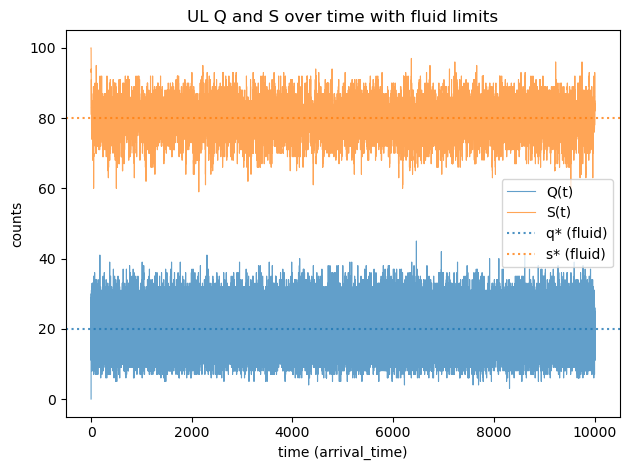

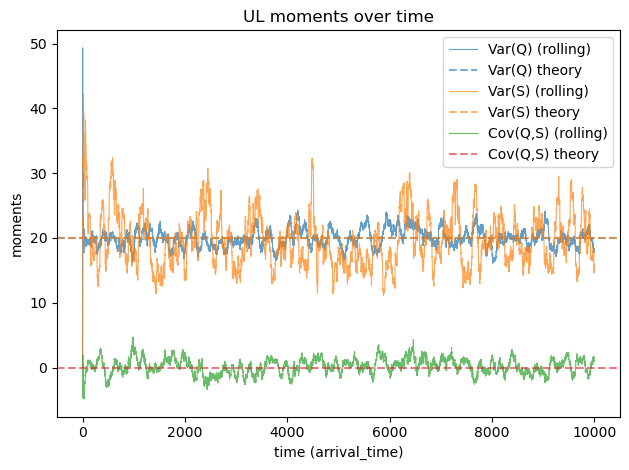

Plotting NC run: λ=100.0, μ=1.0, θ=1.0, p=0.5, γ=1.0, c=150


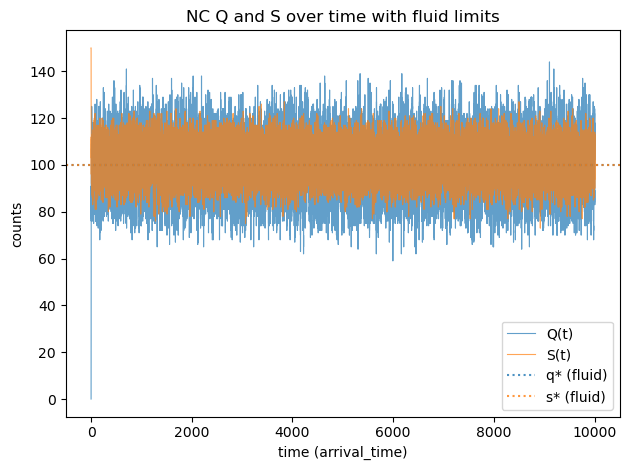

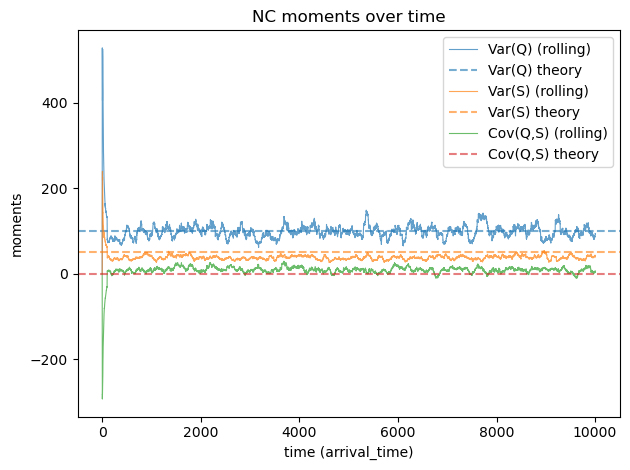

Plotting OL run: λ=100.0, μ=1.0, θ=1.0, p=0.5, γ=1.0, c=100


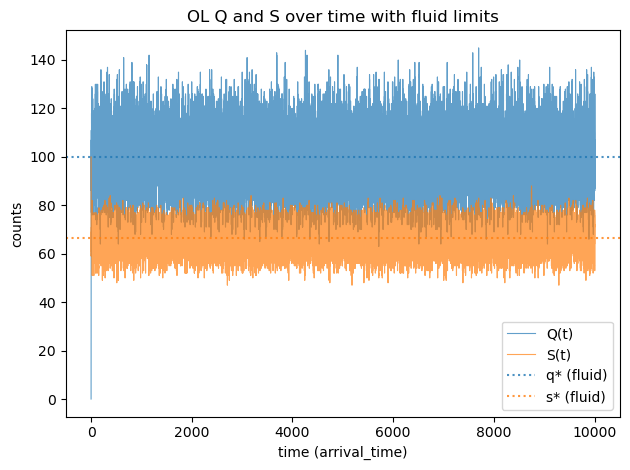

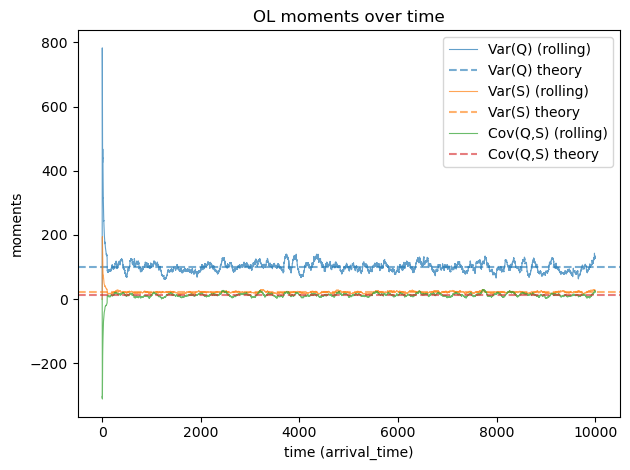

Staffing tables saved under: simulation_results/parameter_sweep_20251124_021950/figures_and_tables
Multi-run figures saved under: simulation_results/parameter_sweep_20251210_233538/individual_runs/figures_and_tables_multi


In [59]:
if __name__ == "__main__":
    example_pipeline()

In [61]:
# -----------------------------
# Distributions for Q, S with Normal overlays
# -----------------------------
from typing import List, Optional
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt, pi, exp

def _normal_pdf(x, mean, var):
    if var <= 0:
        return np.zeros_like(x)
    sigma = sqrt(var)
    return (1.0 / (sigma * sqrt(2 * pi))) * np.exp(-0.5 * ((x - mean) / sigma) ** 2)


def _plot_hist_with_normal(ax, data, mean, var, bins=50, label_hist='hist', label_norm='normal', color='tab:blue'):
    data = pd.Series(data).dropna().values
    if data.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return
    ax.hist(data, bins=bins, density=True, alpha=0.5, color=color, label=label_hist)
    xs = np.linspace(min(data.min(), mean - 4 * sqrt(max(var, 1e-9))),
                     max(data.max(), mean + 4 * sqrt(max(var, 1e-9))), 200)
    ax.plot(xs, _normal_pdf(xs, mean, var), color=color, linewidth=0.9, label=label_norm)


def plot_distributions_single_run(csv_path: str,
                                  window_sec: float,
                                  system: str = 'Erlang-S*',
                                  savepath: Optional[str] = None,
                                  bins: int = 50,
                                  title_prefix: str = ''):
    """
    Plot distributions (hist + Normal overlay) for:
    - Q(t) at arrivals vs N(q*, vqq)
    - S(t) at arrivals vs N(s*, vss)
    """
    if csv_path is None:
        return
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)

    df = pd.read_csv(csv_path)
    df_roll = rolling_stats_from_arrivals(df, window_sec=window_sec, system=system)
    if df_roll is None or df_roll.empty:
        print(f"No rolling stats for {os.path.basename(csv_path)}")
        return

    prm = load_params_for_run(csv_path)
    q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    vqq, vss, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    reg = 'UL' if is_underloaded(prm['lambda'], prm['mu'], prm['p'], prm['gamma'], prm['c']) else 'OL'

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Q ~ N(q*, vqq)
    _plot_hist_with_normal(axes[0], df_roll['q_at_arrival'], mean=q_star, var=vqq, bins=bins, label_hist='Q hist', label_norm='N(q*, vqq)', color='tab:blue')
    axes[0].set_title('Q distribution with N(q*, vqq)')
    axes[0].set_xlabel('Q')

    # S ~ N(s*, vss)
    _plot_hist_with_normal(axes[1], df_roll['s_at_arrival'], mean=s_star, var=vss, bins=bins, label_hist='S hist', label_norm='N(s*, vss)', color='tab:orange')
    axes[1].set_title('S distribution with N(s*, vss)')
    axes[1].set_xlabel('S')

    fig.suptitle(f"Q and S distributions for λ={prm['lambda']}, μ={prm['mu']}, θ={prm['theta']}, p={prm['p']}, γ={prm['gamma']}, c={prm['c']}")
    for a in axes:
        a.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if savepath:
        fname = os.path.join(savepath, f"single_{(title_prefix or reg).replace(' ', '_').lower()}_distributions.png")
        plt.savefig(fname, dpi=180)
    plt.show()


Selected UL CSV: sim_03_UL_drone_delivery_combined_20251210_233741.csv
Selected OL CSV: sim_01_OL_drone_delivery_combined_20251210_233656.csv


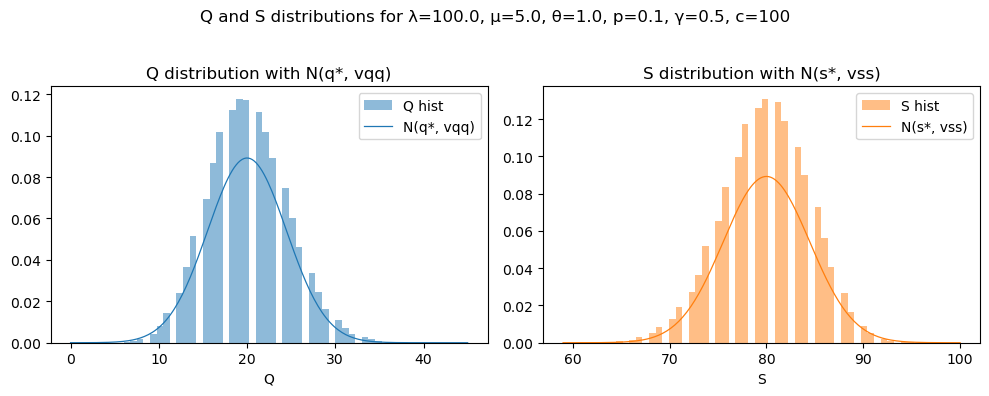

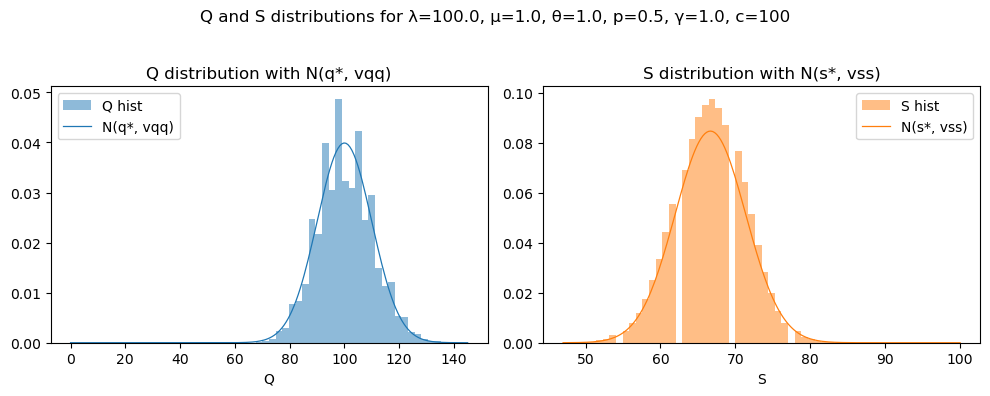

In [62]:
# Inline driver: render distributions for UL and OL (no saving)
from glob import glob

candidate_csvs = []
if os.path.isdir(SWEEP_DIR_IND_RUNS):
    candidate_csvs = glob(os.path.join(SWEEP_DIR_IND_RUNS, '*.csv'))
else:
    candidate_csvs = glob(os.path.join('simulation_results', 'parameter_sweep_*', 'individual_runs', '*.csv'))

# Pick one UL and one OL
ul_csv = None
ol_csv = None
for csv in candidate_csvs:
    try:
        prm = load_params_for_run(csv)
    except Exception:
        continue
    if is_underloaded(prm['lambda'], prm['mu'], prm['p'], prm['gamma'], prm['c']):
        if ul_csv is None:
            ul_csv = csv
    else:
        if ol_csv is None:
            ol_csv = csv
    if ul_csv and ol_csv:
        break

print('Selected UL CSV:', os.path.basename(ul_csv) if ul_csv else None)
print('Selected OL CSV:', os.path.basename(ol_csv) if ol_csv else None)

window_sec = ROLLING_WINDOW_SEC
bins = 60
outdir_runs_multi = os.path.join(SWEEP_DIR_IND_RUNS, "figures_and_tables_multi")

# UL distributions
plot_distributions_single_run(ul_csv, window_sec=window_sec, system='Erlang-S*', savepath=outdir_runs_multi, bins=bins, title_prefix='UL')

# OL distributions
plot_distributions_single_run(ol_csv, window_sec=window_sec, system='Erlang-S*', savepath=outdir_runs_multi, bins=bins, title_prefix='OL')

Found tags: {'02': 100, '01': 100, '03': 100}


/opt/anaconda3/envs/drones/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/drones/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/drones/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/g5/1l4ck1mx63dcvhs2hjk5rw400000gn/T/ipykernel_48110/2248476275.py:68: RuntimeWarning: Mean of empty slice
  merged_mean[col] = np.nanmean(arr, axis=0)
/opt/anaconda3/envs/drones/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/fol

Plot for simulation of λ=100.0, μ=1.0, θ=1.0, p=0.5, γ=1.0, c=150


/var/folders/g5/1l4ck1mx63dcvhs2hjk5rw400000gn/T/ipykernel_48110/2248476275.py:68: RuntimeWarning: Mean of empty slice
  merged_mean[col] = np.nanmean(arr, axis=0)
/opt/anaconda3/envs/drones/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


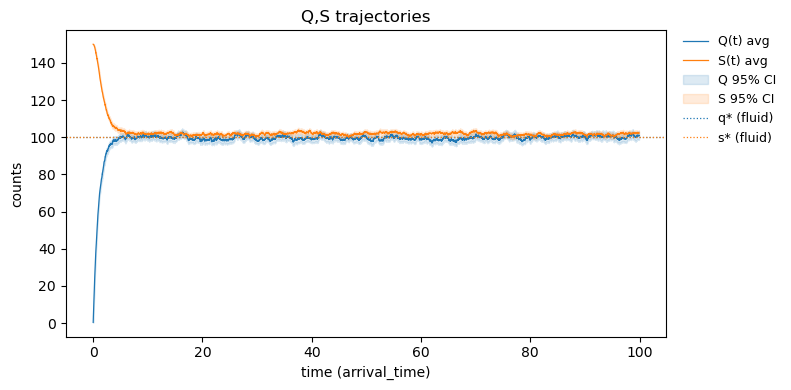

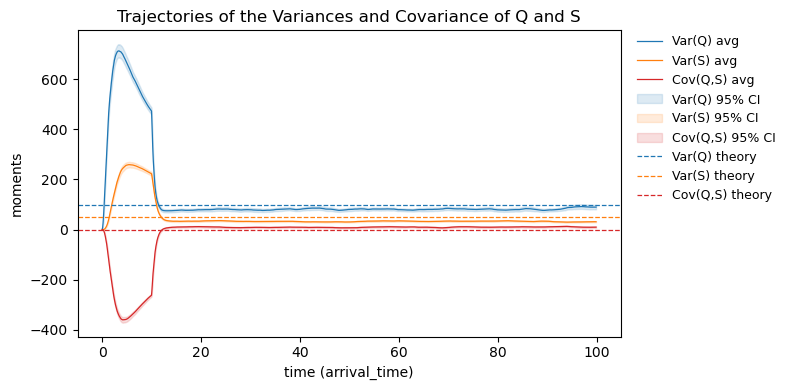

Plot for simulation of λ=100.0, μ=1.0, θ=1.0, p=0.5, γ=1.0, c=100


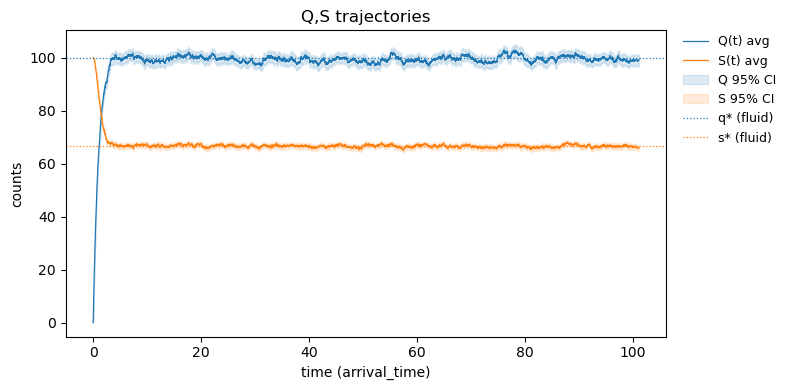

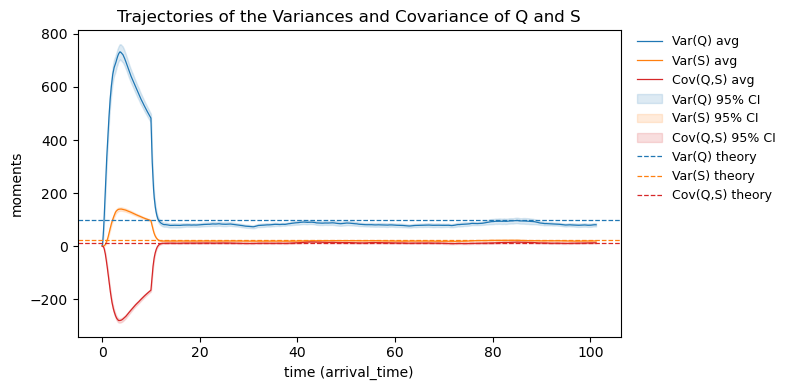

Plot for simulation of λ=100.0, μ=5.0, θ=1.0, p=0.1, γ=0.5, c=100


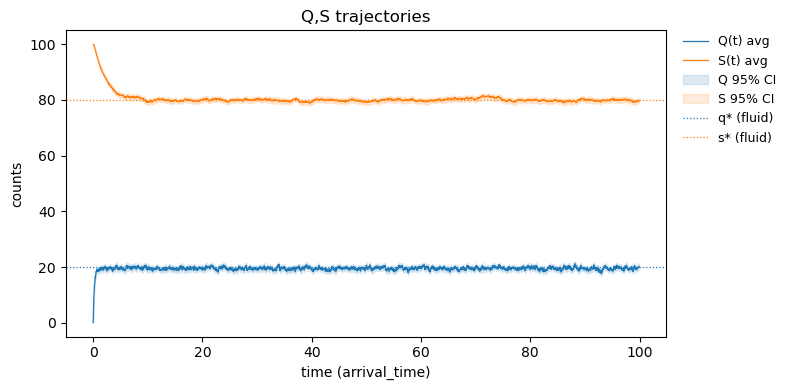

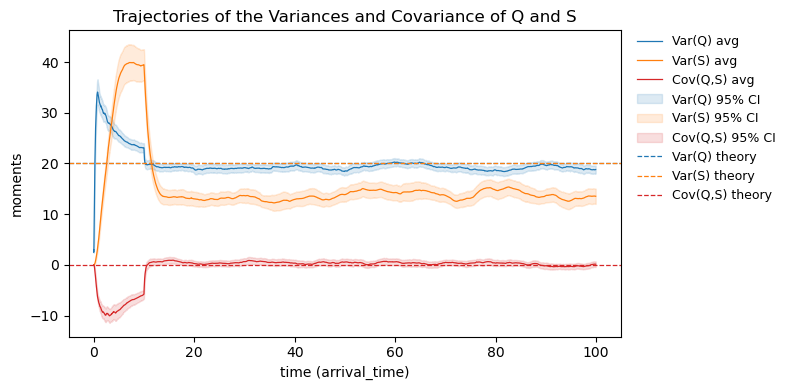

In [97]:
# Average trajectories over 100 runs per parameter set with CIs
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# directory of repeated runs (with individual combined CSV + per-run JSON)
SWEEP_DIR_100_SAME_IND_RUNS = "simulation_results/parameter_sweep_20251212_035925/individual_runs"
source_dir = SWEEP_DIR_100_SAME_IND_RUNS
assert os.path.isdir(source_dir), f'Individual runs dir not found: {source_dir}'

# Output folder for figures
save_dir = os.path.join(os.path.dirname(source_dir), 'figures_and_tables')
os.makedirs(save_dir, exist_ok=True)

# Group runs by parameter-set tag inferred from filename pattern: sim_XX_<TAG>_<run_id>_drone_delivery
run_files = glob.glob(os.path.join(source_dir, '*.csv'))
assert run_files, f'No CSVs found in {source_dir}'

def extract_tag(path):
    name = os.path.basename(path)
    parts = name.split('_')
    # expected: sim, idx, tag, run, ...
    return parts[1] if len(parts) >= 4 else 'unknown'

# Build mapping: tag -> list of CSVs
by_tag = {}
for f in run_files:
    tag = extract_tag(f)
    by_tag.setdefault(tag, []).append(f)

print('Found tags:', {k: len(v) for k, v in by_tag.items()})

# Helper: compute rolling stats per run (returns DataFrame with columns of interest)
columns_keep = ['t', 'q_at_arrival', 's_at_arrival', 'var_q_emp', 'var_s_emp', 'cov_qs_emp']

def rolling_for_run(csv_path, window_sec):
    df = pd.read_csv(csv_path)
    df_roll = rolling_stats_from_arrivals(df, window_sec=ROLLING_WINDOW_SEC, system='Erlang-S*')
    if df_roll is None or df_roll.empty:
        return None
    return df_roll[columns_keep].copy()

# Average over runs for each tag by aligning on t, also compute SE for CIs
avg_results = {}
se_results = {}
for tag, files in by_tag.items():
    dfs = []
    for f in files:
        r = rolling_for_run(f, ROLLING_WINDOW_SEC)
        if r is not None:
            dfs.append(r)
    if not dfs:
        continue
    # Align by nearest t via merge_asof
    dfs_sorted = [d.sort_values('t').reset_index(drop=True) for d in dfs]
    # Use the first run's t as reference grid
    ref = dfs_sorted[0][['t']].copy()
    merged_mean = ref.copy()
    merged_se = ref.copy()
    n_runs = len(dfs_sorted)
    for col in columns_keep[1:]:
        vals = []
        for d in dfs_sorted:
            vals.append(pd.merge_asof(ref, d[['t', col]].sort_values('t'), on='t', direction='nearest')[col])
        arr = np.vstack([v.to_numpy() for v in vals])
        merged_mean[col] = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0, ddof=1) if n_runs > 1 else np.zeros_like(merged_mean[col])
        se = std / np.sqrt(n_runs) if n_runs > 0 else std
        merged_se[col + '_se'] = se
    avg_results[tag] = merged_mean
    se_results[tag] = merged_se

# Plot average trajectories per tag with theoretical lines and 95% CI bands
for tag, avg in avg_results.items():
    # Derive theory from one representative file's parameters
    sample_file = by_tag[tag][0]
    prm = load_params_for_run(sample_file)
    q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    vqq, vss, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    print(f"Plot for simulation of λ={prm['lambda']}, μ={prm['mu']}, θ={prm['theta']}, p={prm['p']}, γ={prm['gamma']}, c={prm['c']}")

    t = avg['t']
    se = se_results[tag]
    z = 1.96  # 95% CI

    plt.figure(figsize=(8,4))
    q_mean = avg['q_at_arrival']; q_se = se['q_at_arrival_se']
    s_mean = avg['s_at_arrival']; s_se = se['s_at_arrival_se']
    plt.plot(t, q_mean, label='Q(t) avg', linewidth=0.9, color='tab:blue')
    plt.plot(t, s_mean, label='S(t) avg', linewidth=0.9, color='tab:orange')
    plt.fill_between(t, q_mean - z*q_se, q_mean + z*q_se, color='tab:blue', alpha=0.15, label='Q 95% CI')
    plt.fill_between(t, s_mean - z*s_se, s_mean + z*s_se, color='tab:orange', alpha=0.15, label='S 95% CI')
    plt.axhline(q_star, linestyle=':', color='tab:blue', linewidth=0.9, label='q* (fluid)')
    plt.axhline(s_star, linestyle=':', color='tab:orange', linewidth=0.9, label='s* (fluid)')
    plt.title(f'Q,S trajectories')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('counts')
    plt.legend()
    plt.tight_layout()
    fig_path = os.path.join(save_dir, f"avg_qs_{tag}.png")
    plt.savefig(fig_path, dpi=180)
    plt.show()

    plt.figure(figsize=(8,4))
    vq_mean = avg['var_q_emp']; vq_se = se['var_q_emp_se']
    vs_mean = avg['var_s_emp']; vs_se = se['var_s_emp_se']
    cov_mean = avg['cov_qs_emp']; cov_se = se['cov_qs_emp_se']
    plt.plot(t, vq_mean, label='Var(Q) avg', linewidth=0.9, color='tab:blue')
    plt.plot(t, vs_mean, label='Var(S) avg', linewidth=0.9, color='tab:orange')
    plt.plot(t, cov_mean, label='Cov(Q,S) avg', linewidth=0.9, color='tab:red')
    plt.fill_between(t, vq_mean - z*vq_se, vq_mean + z*vq_se, color='tab:blue', alpha=0.15, label='Var(Q) 95% CI')
    plt.fill_between(t, vs_mean - z*vs_se, vs_mean + z*vs_se, color='tab:orange', alpha=0.15, label='Var(S) 95% CI')
    plt.fill_between(t, cov_mean - z*cov_se, cov_mean + z*cov_se, color='tab:red', alpha=0.15, label='Cov(Q,S) 95% CI')
    plt.axhline(vqq, linestyle='--', color='tab:blue', linewidth=0.9, label='Var(Q) theory')
    plt.axhline(vss, linestyle='--', color='tab:orange', linewidth=0.9, label='Var(S) theory')
    plt.axhline(vqs, linestyle='--', color='tab:red', linewidth=0.9, label='Cov(Q,S) theory')
    plt.title(f'Trajectories of the Variances and Covariance of Q and S')
    plt.xlabel('time (arrival_time)')
    plt.ylabel('moments')
    plt.legend()
    plt.tight_layout()
    fig_path = os.path.join(save_dir, f"avg_moments_{tag}.png")
    plt.savefig(fig_path, dpi=180)
    plt.show()


Saved: simulation_results/parameter_sweep_20251212_035925/figures_and_tables/run0_distributions_01.png


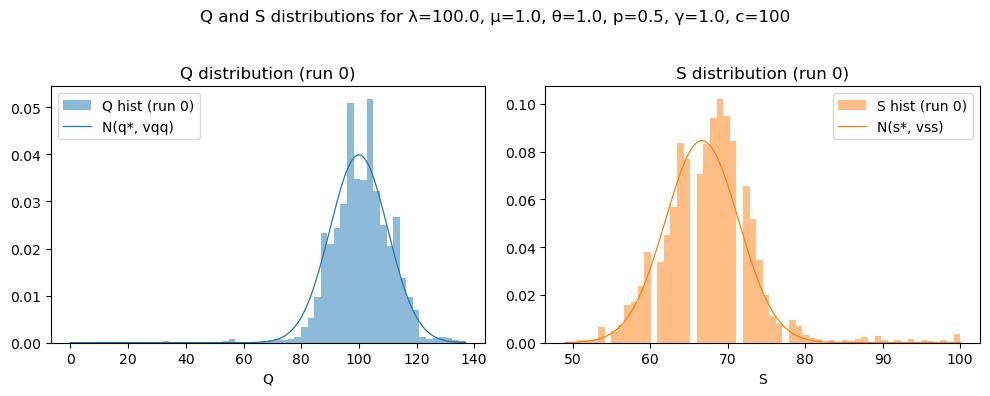

Saved: simulation_results/parameter_sweep_20251212_035925/figures_and_tables/run0_distributions_02.png


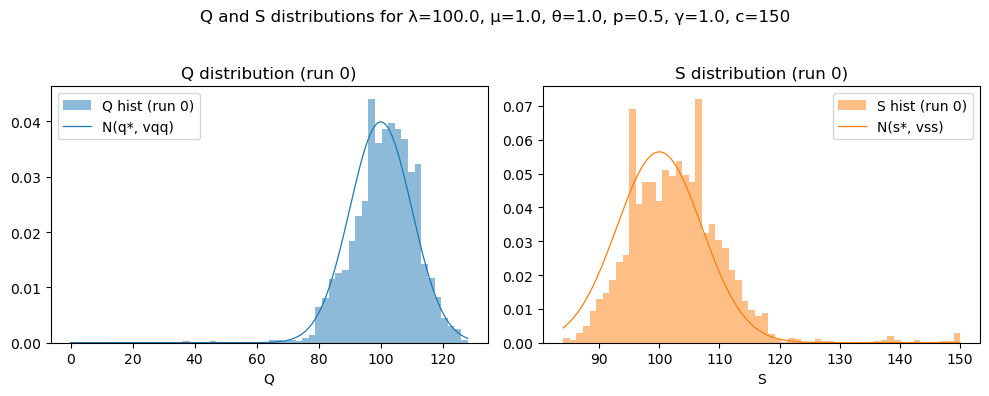

Saved: simulation_results/parameter_sweep_20251212_035925/figures_and_tables/run0_distributions_03.png


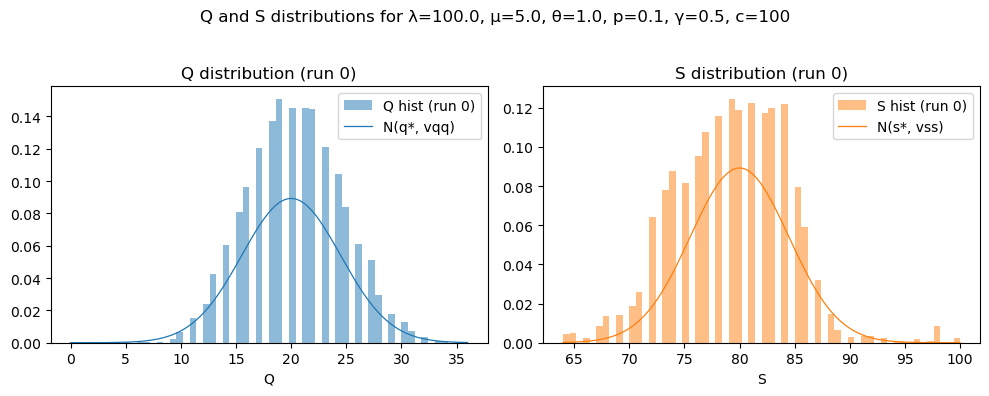

In [70]:
# Pipeline: distributions for run_id=0 per parameter set (Q and S with normals)
# Find only run 0 files: sim_<idx>_<tag>_0_drone_delivery_combined_*.csv
candidate_files = glob.glob(os.path.join(source_dir, 'sim_*_*_0_drone_delivery_combined_*.csv'))
assert candidate_files, f"No run_id=0 combined CSVs found in {source_dir}"

# Helper to overlay Normal(mean, var)
def _normal_pdf(x, mean, var):
    if var <= 0:
        return np.zeros_like(x)
    sigma = np.sqrt(var)
    return (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

bins = 60
for csv_path in sorted(candidate_files):
    df = pd.read_csv(csv_path)
    df_roll = rolling_stats_from_arrivals(df, window_sec=ROLLING_WINDOW_SEC, system='Erlang-S*')
    if df_roll is None or df_roll.empty:
        print(f"Skipping (no rolling stats): {os.path.basename(csv_path)}")
        continue

    prm = load_params_for_run(csv_path)
    q_star, s_star = fluid_fixed_point(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])
    vqq, vss, vqs = diffusion_second_moments(prm['lambda'], prm['mu'], prm['theta'], prm['p'], prm['gamma'], prm['c'])

    q_vals = df_roll['q_at_arrival'].dropna().values
    s_vals = df_roll['s_at_arrival'].dropna().values

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Q distribution for run 0
    axes[0].hist(q_vals, bins=bins, density=True, alpha=0.5, color='tab:blue', label='Q hist (run 0)')
    xs_q = np.linspace(q_vals.min(), q_vals.max(), 200)
    axes[0].plot(xs_q, _normal_pdf(xs_q, q_star, vqq), color='tab:blue', linewidth=0.9, label='N(q*, vqq)')
    axes[0].set_title('Q distribution (run 0)')
    axes[0].set_xlabel('Q')
    axes[0].legend()

    # S distribution for run 0
    axes[1].hist(s_vals, bins=bins, density=True, alpha=0.5, color='tab:orange', label='S hist (run 0)')
    xs_s = np.linspace(s_vals.min(), s_vals.max(), 200)
    axes[1].plot(xs_s, _normal_pdf(xs_s, s_star, vss), color='tab:orange', linewidth=0.9, label='N(s*, vss)')
    axes[1].set_title('S distribution (run 0)')
    axes[1].set_xlabel('S')
    axes[1].legend()

    fig.suptitle(f"Q and S distributions for λ={prm['lambda']}, μ={prm['mu']}, θ={prm['theta']}, p={prm['p']}, γ={prm['gamma']}, c={prm['c']}")
    plt.tight_layout(rect=[0,0,1,0.95])

    # Save per-file figure with concise tag
    name = os.path.basename(csv_path)
    parts = name.split('_')
    tag = parts[1] if len(parts) >= 4 else 'unknown'
    fig_path = os.path.join(save_dir, f"run0_distributions_{tag}.png")
    plt.savefig(fig_path, dpi=180)
    print(f"Saved: {fig_path}")
    plt.show()


In [80]:
import seaborn as sns

def scatter_compare(df, xcol, ycol, hue=None, title=None, 
                    figsize=(6,6), alpha=0.4, s=20, line=True):
    """
    df : DataFrame
    xcol : str (e.g., 'delay_a' for analytic)
    ycol : str (e.g., 'delay_s' for simulation)
    hue  : optional column to color by (e.g., 'regime', 'p', or 'lambda')
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=hue, alpha=alpha, s=s)

    # reference line y=x
    if line:
        lim_min = min(df[xcol].min(), df[ycol].min())
        lim_max = max(df[xcol].max(), df[ycol].max())
        plt.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=1)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)

    plt.xlabel(f"{xcol} (analytic/diffusion)")
    plt.ylabel(f"{ycol} (simulation)")
    plt.title(title if title else f"{ycol} vs {xcol}")
    plt.tight_layout()
    plt.show()

delta = 1e-4

def classify_regime_for_df(row, delta=delta):
    L = row['lambda']/row['mu'] + (row['lambda'] * row['p'])/row['gamma']
    if row['c'] > L + delta:
        return "UL"
    elif row['c'] < L - delta:
        return "OL"
    else:
        return "NC"



Index(['sim_id', 'timestamp', 'lambda', 'mu', 'theta', 'c', 'p', 'gamma',
       'rho', 'utilization', 'delay_prob_a', 'delay_prob_s', 'abandon_rate_a',
       'abandon_rate_s', 'avg_wait_a', 'avg_wait_s', 'avg_queue_a',
       'avg_queue_s', 'avg_servers_avail_a', 'avg_servers_avail_s',
       'avg_servers_charging_s', 'avg_system_size_a', 'avg_system_size_s',
       'var_queue_a', 'var_queue_s', 'var_servers_avail_a',
       'var_servers_avail_s', 'cov_queue_servers_a', 'cov_queue_servers_s',
       'var_system_size_a', 'var_system_size_s', 'delay_improvement',
       'abandon_improvement', 'wait_improvement', 'queue_improvement'],
      dtype='object')


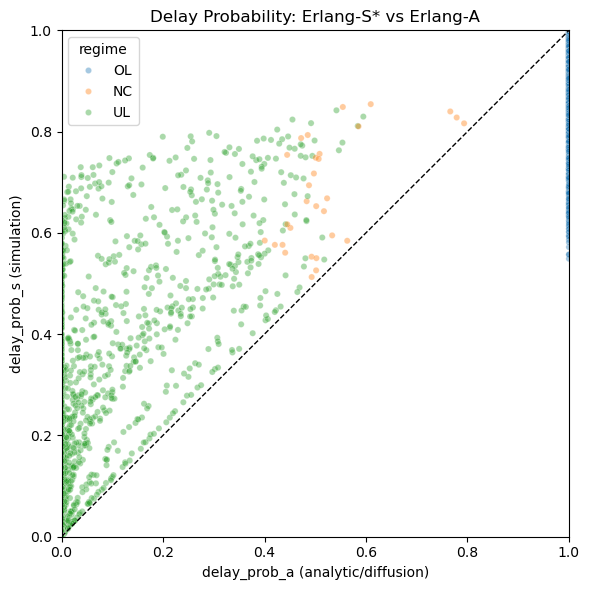

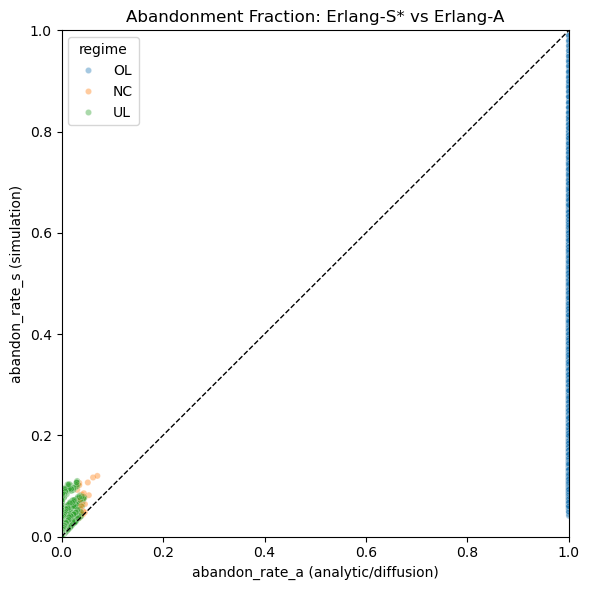

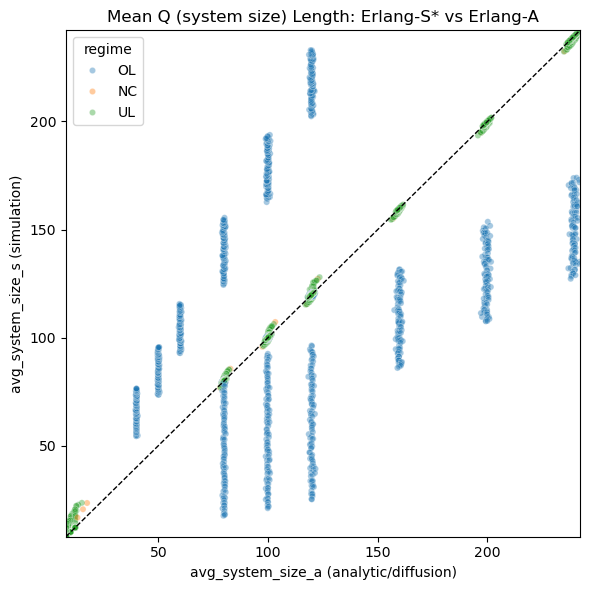

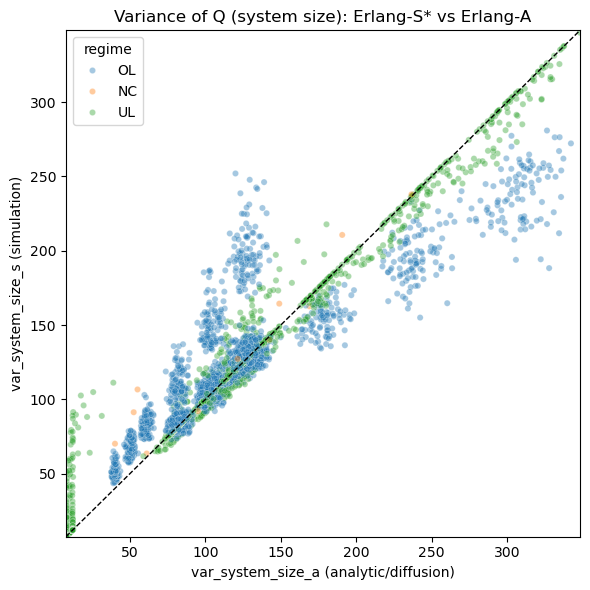

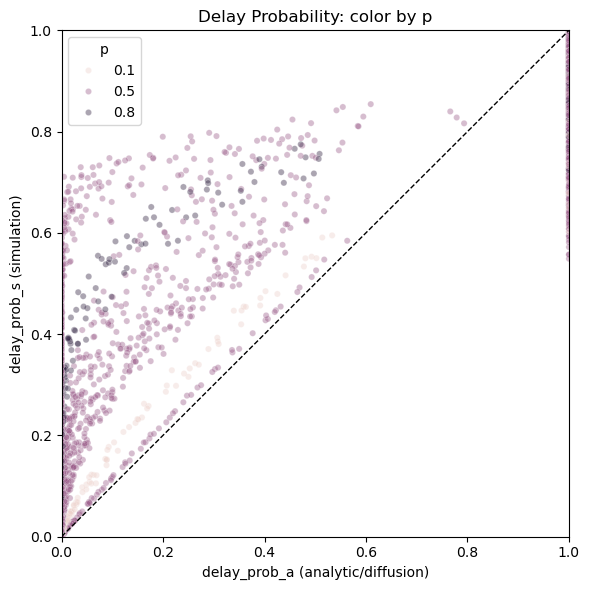

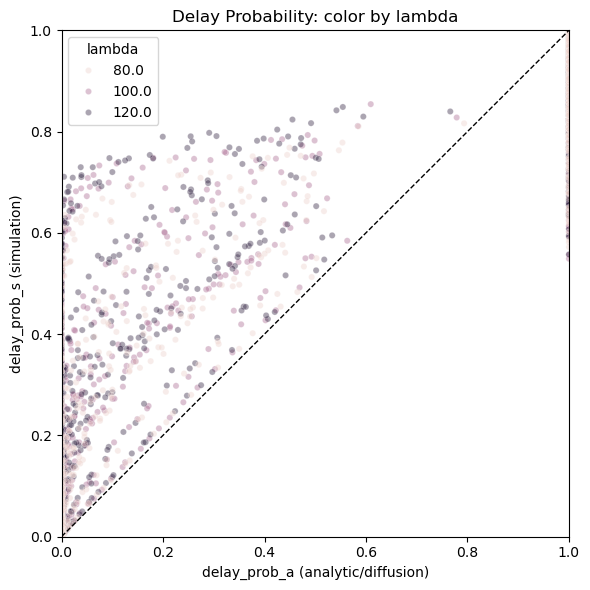

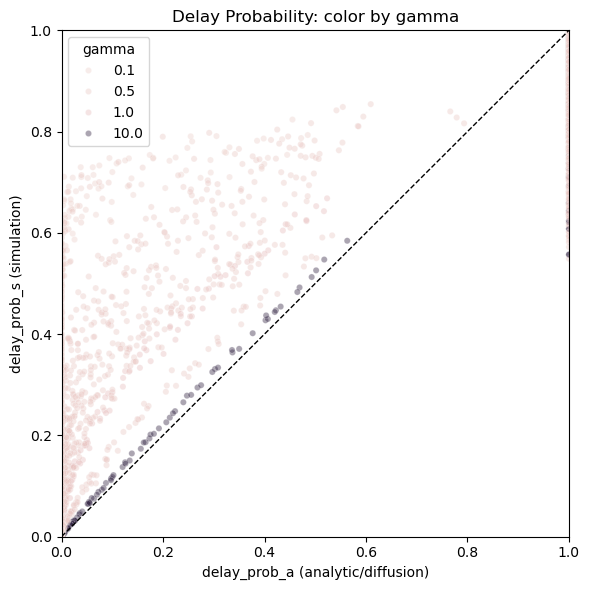

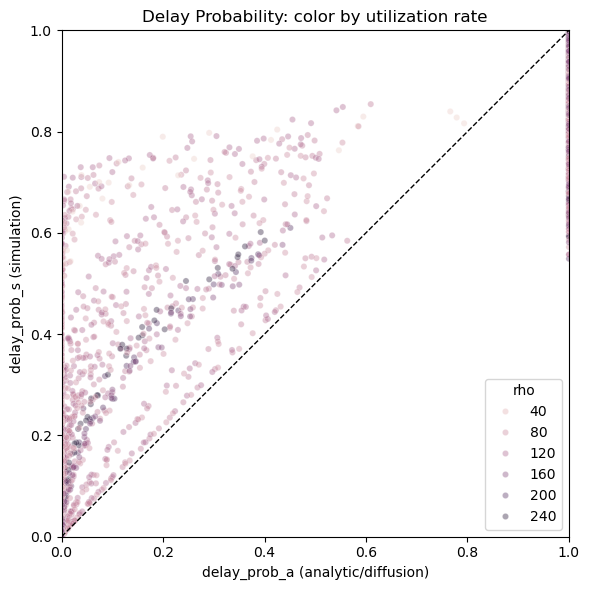

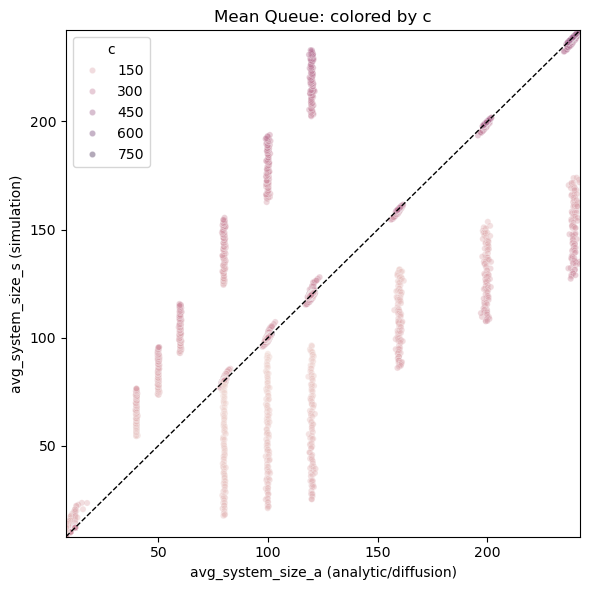

In [91]:
summary_df, params_meta = load_sweep_summary(SWEEP_DIR)
print(summary_df.columns)

summary_df_w_regime = summary_df.copy()
summary_df_w_regime['regime'] = summary_df_w_regime.apply(classify_regime_for_df, axis=1)

scatter_compare(
    summary_df_w_regime, 
    xcol="delay_prob_a", 
    ycol="delay_prob_s", 
    hue="regime", 
    title="Delay Probability: Erlang-S* vs Erlang-A"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="abandon_rate_a", 
    ycol="abandon_rate_s", 
    hue="regime",
    title="Abandonment Fraction: Erlang-S* vs Erlang-A"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="avg_system_size_a", 
    ycol="avg_system_size_s", 
    hue="regime",
    title="Mean Q (system size) Length: Erlang-S* vs Erlang-A"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="var_system_size_a", 
    ycol="var_system_size_s", 
    hue="regime",
    title="Variance of Q (system size): Erlang-S* vs Erlang-A"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="delay_prob_a", 
    ycol="delay_prob_s",
    hue="p",
    title="Delay Probability: color by p"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="delay_prob_a", 
    ycol="delay_prob_s",
    hue="lambda",
    title="Delay Probability: color by lambda"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="delay_prob_a", 
    ycol="delay_prob_s",
    hue="gamma",
    title="Delay Probability: color by gamma"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="delay_prob_a", 
    ycol="delay_prob_s",
    hue="rho",
    title="Delay Probability: color by utilization rate"
)

scatter_compare(
    summary_df_w_regime, 
    xcol="avg_system_size_a", 
    ycol="avg_system_size_s", 
    hue="c",
    title="Mean Queue: colored by c"
)



In [92]:
summary_df_w_regime['load_center_L'] = (
    summary_df_w_regime['lambda'] / summary_df_w_regime['mu']
    + (summary_df_w_regime['lambda'] * summary_df_w_regime['p']) / summary_df_w_regime['gamma']
)


def plot_delay_vs_c_for_group(group: pd.DataFrame,
                              show_erlang_a=True,
                              show_threshold=True):
    """
    group: a subset of the dataframe with fixed (lambda, mu, theta, p, gamma)
    and varying c.
    """
    # Sort by c so the line is nice
    g = group.sort_values('c')

    lam   = g['lambda'].iloc[0]
    mu    = g['mu'].iloc[0]
    theta = g['theta'].iloc[0]
    p     = g['p'].iloc[0]
    gamma = g['gamma'].iloc[0]

    plt.figure(figsize=(6, 4))

    # Erlang-S* delay probability vs c
    plt.plot(g['c'], g['delay_prob_s'],
             marker='o', linestyle='-', label='Erlang-S* (sim)')

    # Optional: Erlang-A baseline vs c, if present
    if show_erlang_a and 'delay_prob_a' in g.columns:
        plt.plot(g['c'], g['delay_prob_a'],
                 marker='s', linestyle='--', label='Erlang-A (sim)')

    # Optional: vertical line at fluid threshold L
    if show_threshold and 'load_center_L' in g.columns:
        L = g['load_center_L'].iloc[0]
        plt.axvline(L, color='k', linestyle=':', label=f'Fluid threshold L≈{L:.1f}')

    plt.xlabel('Number of servers c')
    plt.ylabel('Delay probability')
    plt.ylim(-0.02, 1.02)

    plt.title(
        f"Delay vs c  (λ={lam}, μ={mu}, θ={theta}, p={p}, γ={gamma})"
    )

    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()



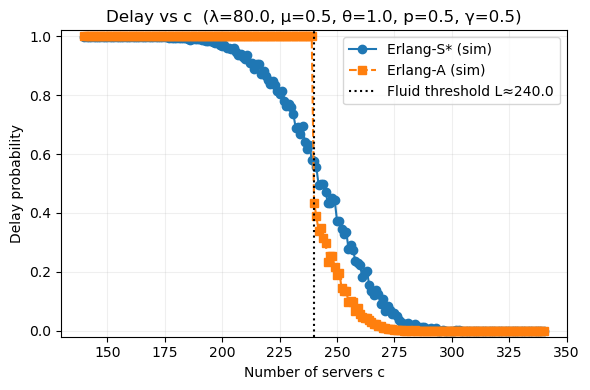

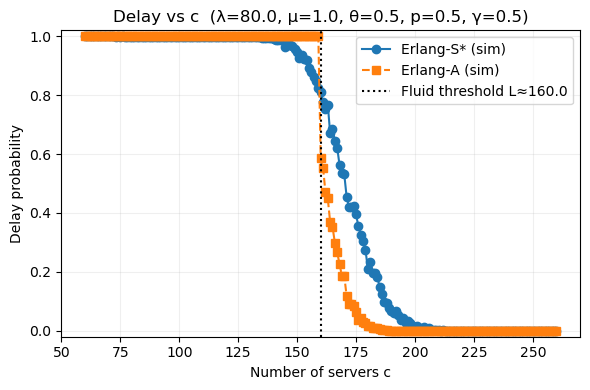

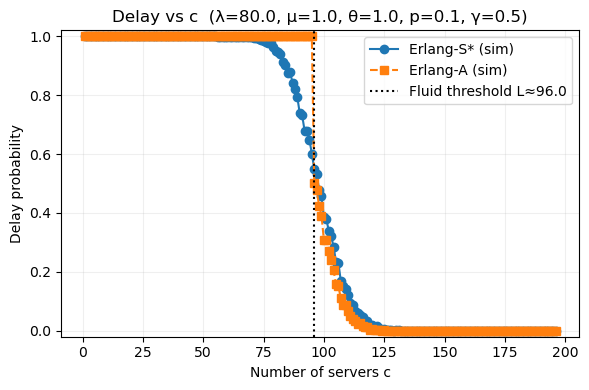

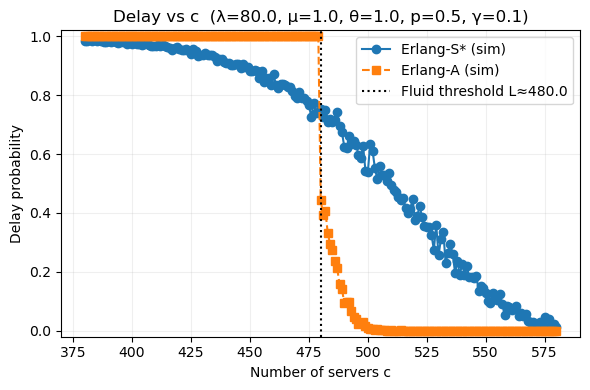

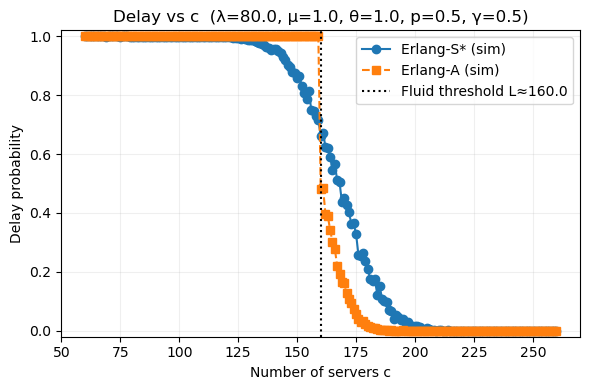

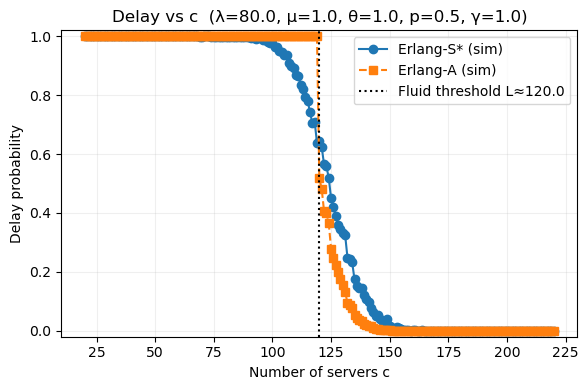

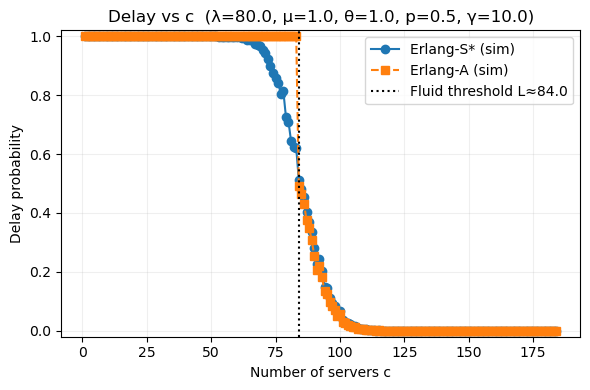

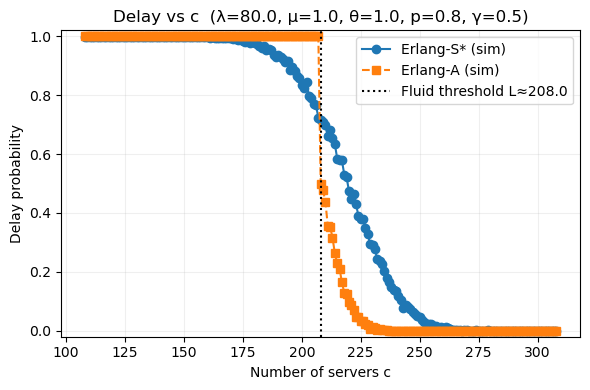

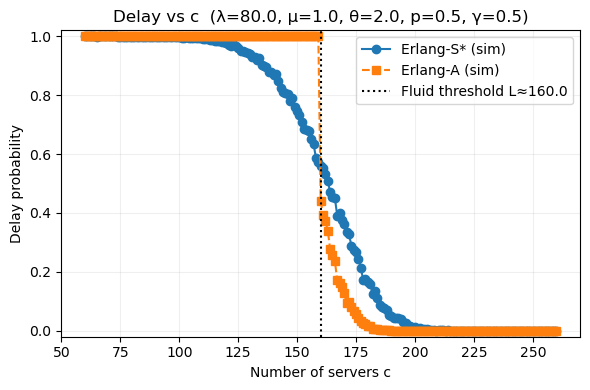

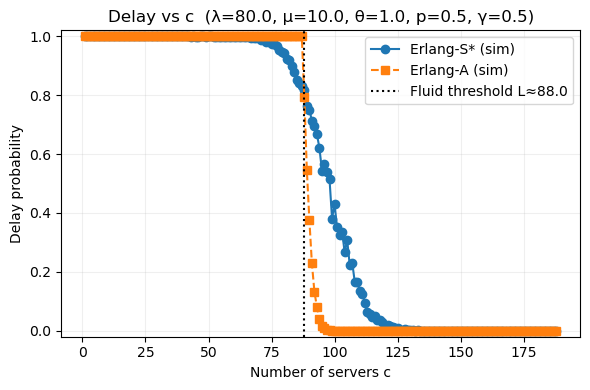

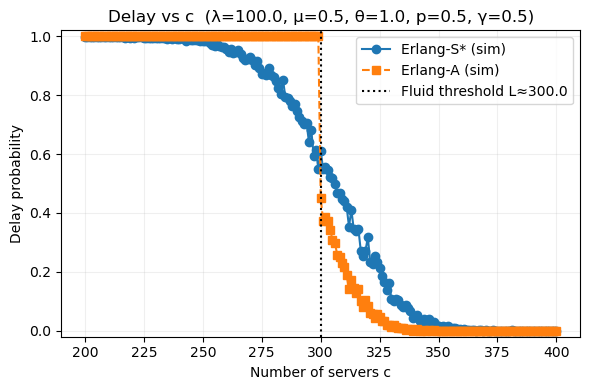

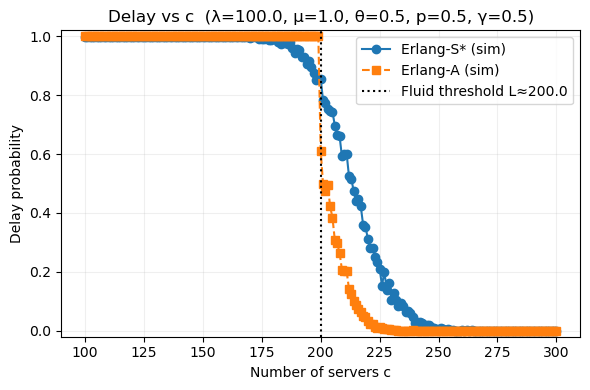

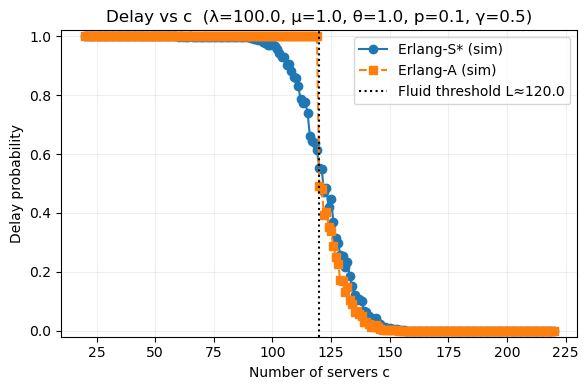

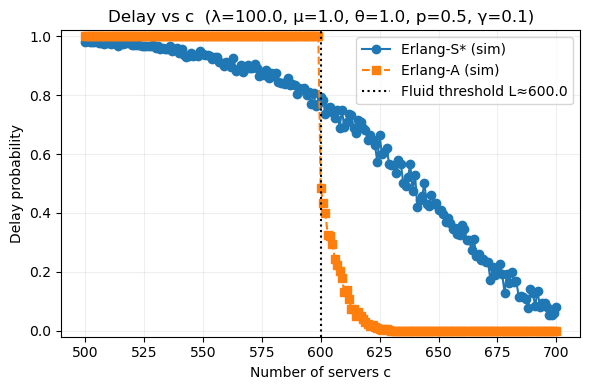

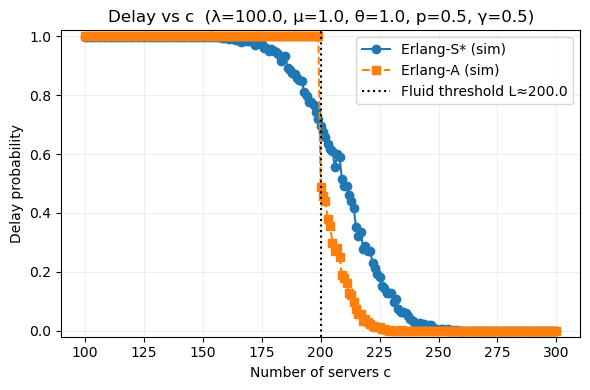

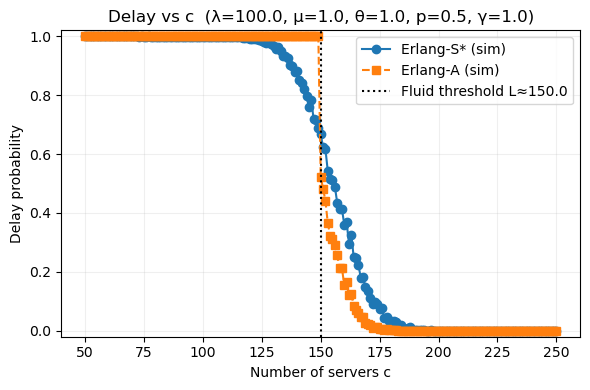

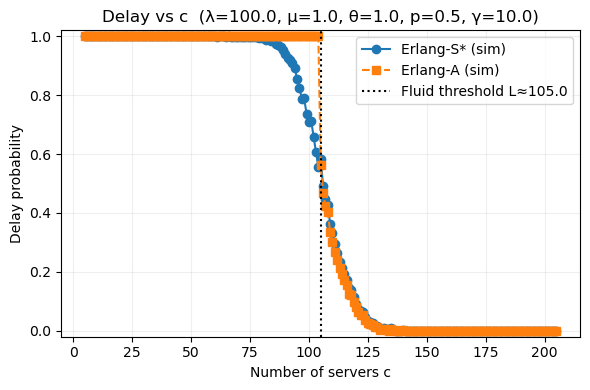

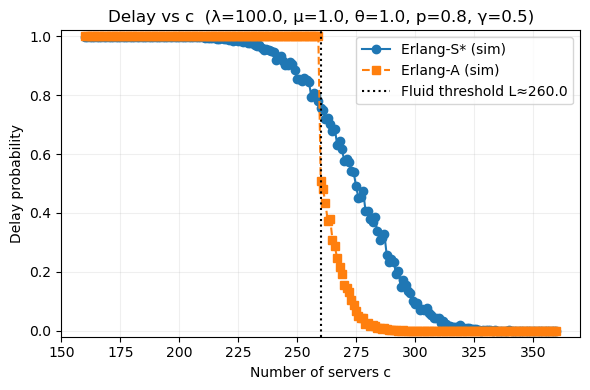

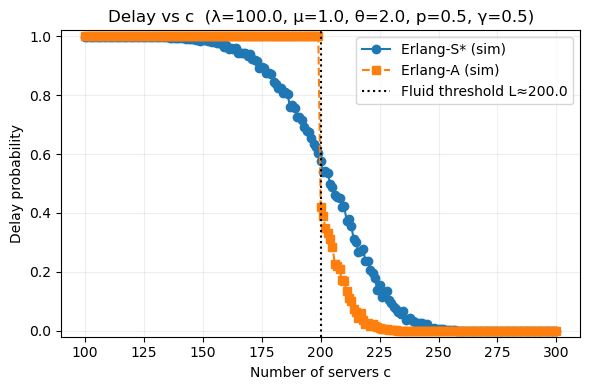

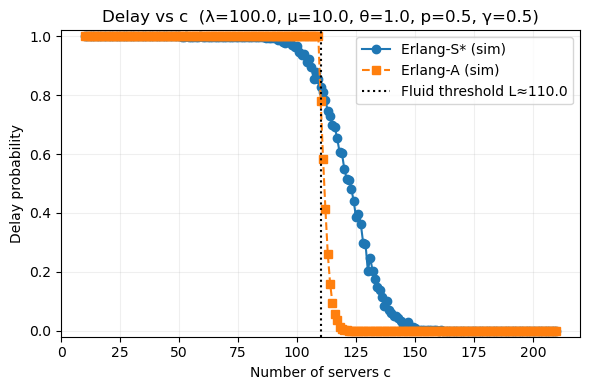

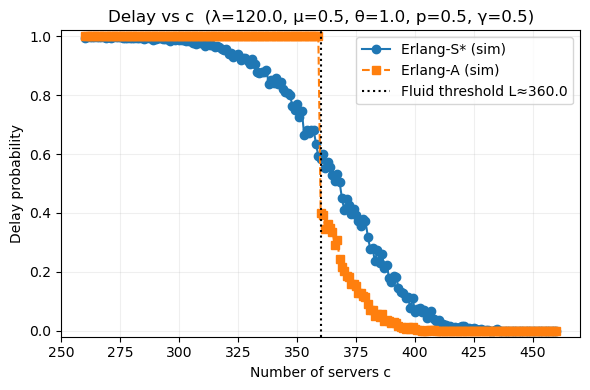

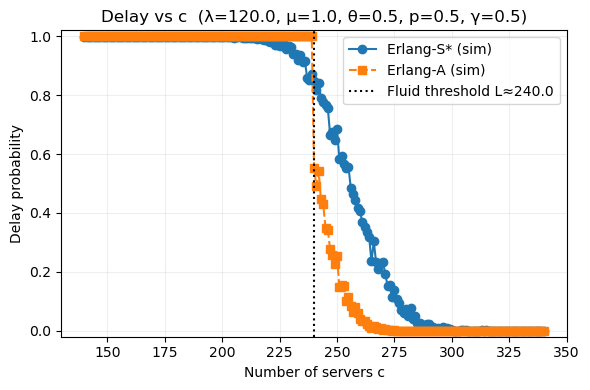

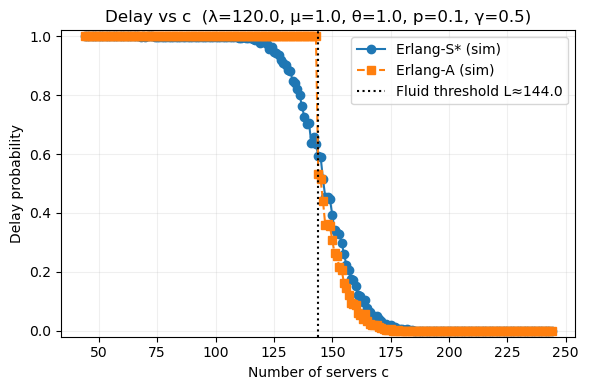

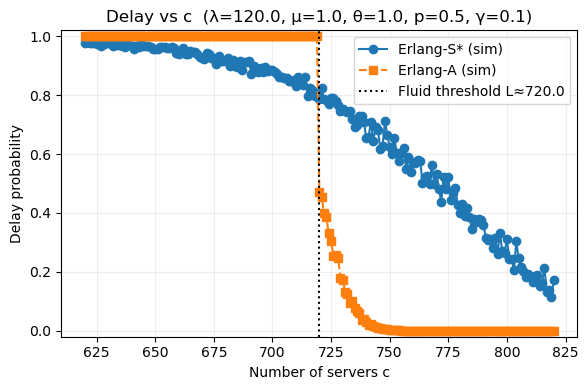

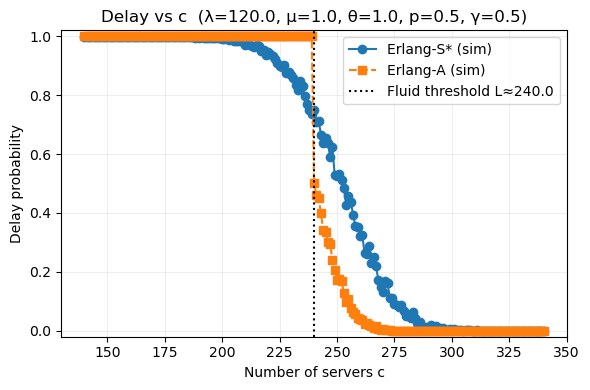

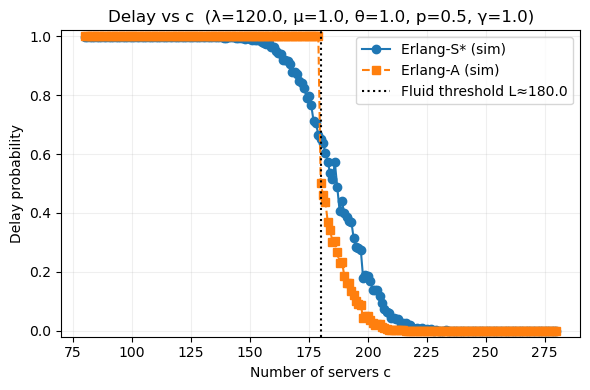

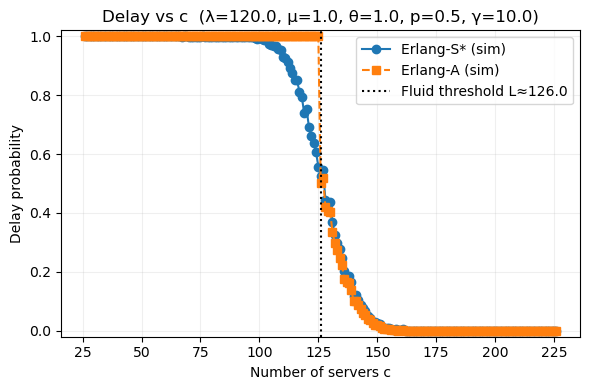

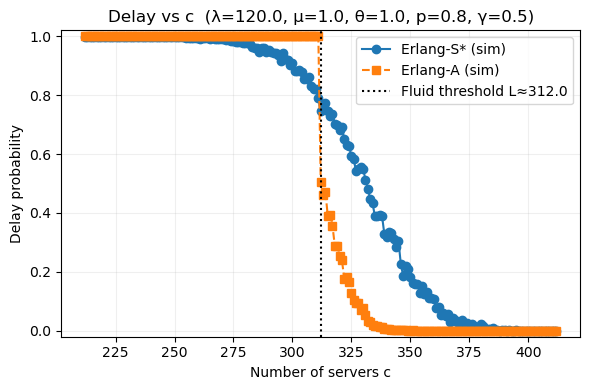

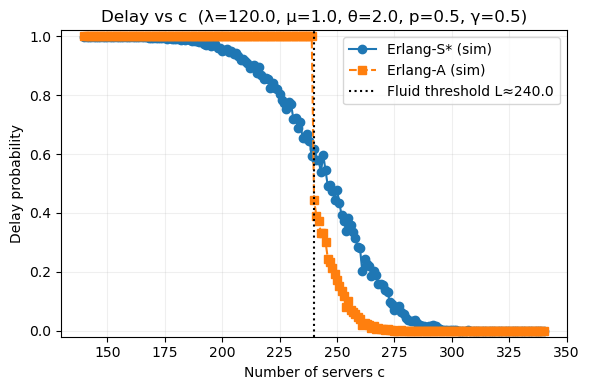

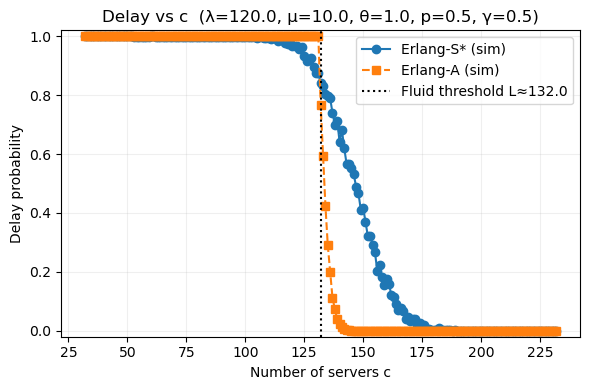

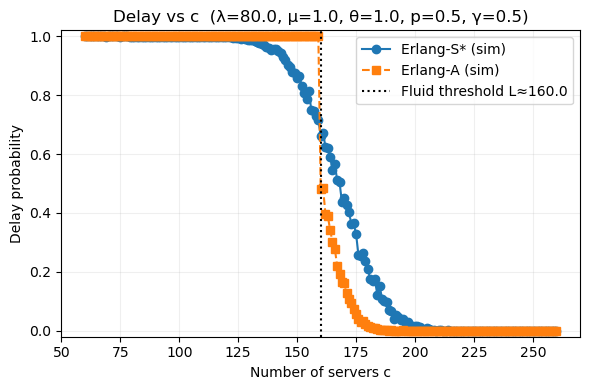

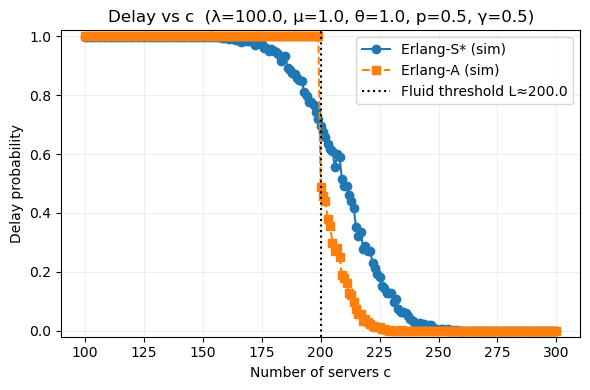

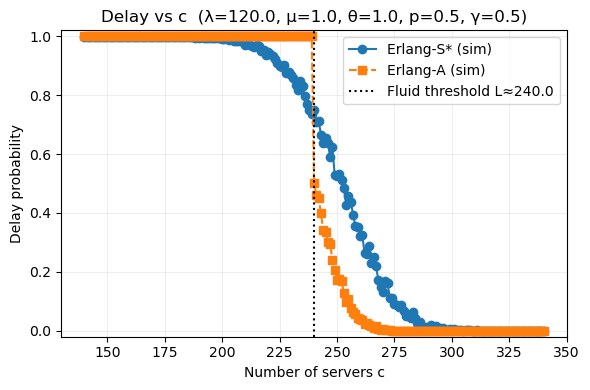

In [94]:
# Assuming summary_df_w_regime already has load_center_L and regime
base_cols = ['lambda', 'mu', 'theta', 'p', 'gamma']

grouped = summary_df_w_regime.groupby(base_cols)

# Option A: plot for *all* base profiles (might be many figures)
for base_params, group in grouped:
    plot_delay_vs_c_for_group(group)

mask = (summary_df_w_regime['mu'] == 1.0) & (summary_df_w_regime['p'] == 0.5) & (summary_df_w_regime['theta'] == 1.0) & (summary_df_w_regime['gamma'] == 0.5)
filtered = summary_df_w_regime[mask]

grouped = filtered.groupby(base_cols)

for base_params, group in grouped:
    plot_delay_vs_c_for_group(group)

